In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
# from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
#import seaborn as sns

from sbi.inference import infer, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import pickle
import scipy.io

from scipy.interpolate import interp1d
import re

from FACTS_Modules.TaskSFCLaw import TaskSFCLaw
from FACTS_Modules.AcousticSynthesis import AcousticSynthesis
import numpy as np
import pdb

from FACTS_Modules.LWPR_Model.lwpr import LWPR
from abc import ABC, abstractmethod

from FACTS_Modules import util
from FACTS_Modules import seutil

import pandas as pd
import seaborn as sns
from scipy import stats
import math


In [3]:
def FACTS(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI_Al.ini'
    # gFile='GesturalScores/KimetalOnlinepert.G'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)
    # print('DEBUGG')
    # Replace the parameter value from ini file
    #pdb.set_trace()
    # try:
    if theta.dim() > 1:
#             pdb.set_trace()
        #print(theta.numel())
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
        #config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[0][3].item())
        #config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[0][4].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[0][5].item())
        
        config['TaskStateEstimator']['AUKF_Rmult_for_pert'] = str(theta[0][6].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[0][6].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[0][7].item())
        
#         config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())

        config['TaskStateEstimator']['AUKF_learning_rate_R'] = str(theta[0][8].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_learning_rate_Q'] = str(theta[0][8].item()) # Let these two be the same based on MS and ablation analysis
        
        config['TaskStateEstimator']['AUKF_learning_rate_P'] = str(theta[0][9].item())

        config['TaskStateEstimator']['sensory_error_threshold'] = str(theta[0][10].item())
        
        
    else:
        #pdb.set_trace()
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
        #config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[3].item())
        #config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[4].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[5].item())
        
        config['TaskStateEstimator']['AUKF_Rmult_for_pert'] = str(theta[6].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[6].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[7].item())

        config['TaskStateEstimator']['AUKF_learning_rate_R'] = str(theta[8].item()) # Let these two be the same based on MS and ablation analysis
        config['TaskStateEstimator']['AUKF_learning_rate_Q'] = str(theta[8].item()) # Let these two be the same based on MS and ablation analysis

        config['TaskStateEstimator']['AUKF_learning_rate_P'] = str(theta[9].item())

        config['TaskStateEstimator']['sensory_error_threshold'] = str(theta[10].item())
        

        # Note from Alvince, need to pass this in when est delay != actual delay  
#         config['SensoryDelay']['Auditory_delay']  = '165'
#         config['SensoryDelay']['Somato_delay']  = '165'

        # Note from Alvince, need to pass this in  for TSE    
        config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
        config['ArticStateEstimator']['Somato_sensor_scale']  = config['SensoryDelay']['Auditory_delay'] 

    # except Exception as e:
    #     print(e)
    #     pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    #print(config['ArticStateEstimator']['cc_discount_from_delay'])
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    buffer_size_auditory = int(float(config['SensoryDelay']['Auditory_delay']) / 5)  # default used to be 20
    buffer_size_somato = int(float(config['SensoryDelay']['Somato_delay']) / 5)
    buffer_size = max(buffer_size_auditory, buffer_size_somato)
    
    x_tilde_delaywindow = np.full([buffer_size,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([buffer_size,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+buffer_size,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+buffer_size,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+buffer_size,3])

    #pdb.set_trace()
    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.
        all_adotdot = []

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
                all_adotdot.append(adotdot)
            


        # x1_pred = np.array(model.task_state_estimator.all_internal_x1_prediction)
        # plt.plot(range(x1_pred.shape[0]), x1_pred)
        #pdb.set_trace()
        #P_over_time = np.array(model.task_state_estimator.all_P)
        #plt.plot(P_over_time)
        #plt.show()

        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)

        plot_trial = False 
        if plot_trial:
            plt.figure()
            single_trial_plots('baseline', 
                                    trial, a_tilde_record_alltrials, 
                                    a_tilde_record_alltrials, formant_record_alltrials, 
                                    predict_formant_record_alltrials, x_tilde_record_alltrials, 
                                    [ini, gFile], formants_produced_record_alltrials)
            #pdb.set_trace() # Test if we can print model.
            plt.figure()
            all_Y = np.array(model.task_state_estimator.all_Y)
            plt.plot(all_Y[:,0,:])
            plt.title('Y from TSE Auditory Prediction')

            plt.figure()
            all_y = np.array(model.task_state_estimator.all_y)
            plt.plot(all_y[:,0])
            plt.title('y from TSE Auditory Prediction')
            plt.show()

            #pdb.set_trace()
            a2t_xtilde = np.array(model.task_state_estimator.artic_to_task_xtilde)
            plt.plot(a2t_xtilde)
            plt.title('artic_to_task_xtilde')
            plt.show()

            plt.figure()
            tse_delay_y = np.array(model.task_state_estimator.all_delay_y)
            plt.plot(tse_delay_y[:,0])
            plt.title('tse_delay_y')
            plt.show()

            plt.figure()
            all_formant_with_noise = np.array(model.task_state_estimator.all_formant_with_noise)
            plt.plot(all_formant_with_noise[:,0])
            plt.title('all_formant_with_noise')
            plt.show()


            plt.figure()
            all_X1 = np.array(model.task_state_estimator.all_X1)
            plt.plot(all_X1[:,:,0])
            plt.title('X1 into TSE Aud Predict')
            plt.show()

            plt.figure()
            all_adotdot = np.array(all_adotdot)
            print(all_adotdot.shape)
            plt.plot(all_adotdot)
            plt.title('adotdot')
            plt.show()

            plt.show()

        #print(f"formant_record_alltrials {formant_record_alltrials}")
        #print(f"formants_produced_record_alltrials {formants_produced_record_alltrials}")
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return torch.from_numpy( formants_produced_record_alltrials[:,:,0].squeeze() )



def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


# Model.py runs all major FACTS modules. Modules that are 
# carried out in each time step are listed in the method 
# "run_one_timestep." model_factory builds FACTS based on 
# the model architecture specified in config files. 

# Under "Hierarchical_xdotdot," for example, the task 
# state estimator type is defined as lwpr. 

def model_factory(config):
    if 'ModelArchitecture' in config.keys():
        if config['ModelArchitecture']['architecture'] == 'classic': return Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical': return Hierarchical_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_articsfcupdate': return Hierarchical_ArticSFCUpdate_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_xdotdot': return Hierarchical_xdotdot(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_JacUpdateDebug': return Hierarchical_JacUpdateDebug(config)
    return Model(config)


# parent class
class Model():
    def __init__(self,model_configs):
        self.task_sfc_law = TaskSFCLaw()
        self.artic_sfc_law = self.artic_sfc_law_factory(model_configs['ArticSFCLaw'])
        self.artic_kinematics = self.artic_kinematics_factory(model_configs)
        self.acoustic_synthesis = AcousticSynthesis(model_configs['AcousticSynthesis'])
        self.auditory_perturbation = self.auditory_perturbation_factory(model_configs)
        self.sensory_system_noise = self.sensory_system_noise_factory(model_configs)
        self.sensory_system_delay = self.sensory_system_delay_factory(model_configs)
        R_Auditory = self.sensory_system_noise.get_R_Auditory()
        R_Somato = self.sensory_system_noise.get_R_Somato()
        self.artic_state_estimator = self.ase_factory(model_configs,R_Auditory,R_Somato)
        self.task_state_estimator = self.tse_factory(model_configs['TaskStateEstimator'],R_Auditory,R_Somato)
        #self.state_estimator = self._state_estimator_factory(model_configs,R_Auditory,R_Somato)
        
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, y_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,formants_noise,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde)

        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot, y_hat
        
    # Factory methods
    def artic_sfc_law_factory(self,configs):
        model_type = configs['model_type']
        #print('Artic SFC Law Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.ArticSFCLaw import ArticSFCLaw_LWPR_noupdate
            artic_sfc_law = ArticSFCLaw_LWPR_noupdate(configs)
        return artic_sfc_law
    
    def artic_kinematics_factory(self,model_configs):
        if 'ArticKinematics' in model_configs.sections():
            from FACTS_Modules.ArticKinematics import ArticKinematics_Noise
            artic_kinematics = ArticKinematics_Noise(model_configs['ArticKinematics'])
        else:
            from FACTS_Modules.ArticKinematics import ArticKinematics
            artic_kinematics = ArticKinematics()
        return artic_kinematics
    
    def sensory_system_noise_factory(self,model_configs):
        if 'SensoryNoise' in model_configs.sections():
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise
            sensory_system_noise = SensorySystemNoise(model_configs['SensoryNoise'])
        else:
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise_None
            sensory_system_noise = SensorySystemNoise_None()
        return sensory_system_noise

    def sensory_system_delay_factory(self,model_configs):
        if 'SensoryDelay' in model_configs.sections():
            from FACTS_Modules.SensorySystemDelay import SensorySystemDelay
            sensory_system_delay = SensorySystemDelay(model_configs['SensoryDelay'])
        return sensory_system_delay

    def auditory_perturbation_factory(self,model_configs):
        if 'AudPerturbation' in model_configs.sections():
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation
            auditory_perturbation = AuditoryPerturbation(model_configs['AudPerturbation'])
        else:
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation_None
            auditory_perturbation = AuditoryPerturbation_None()
        return auditory_perturbation
    
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':
                from FACTS_Modules.ArticStateEstimator import ASE_UKF_Classic
                artic_state_estimator = ASE_UKF_Classic(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Classic
            task_state_estimator = TSE_LWPR_Classic(tse_configs)
        return task_state_estimator
    
class Hierarchical_Model(Model):
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':   
                artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)             
                # if 'Somato_sensor_scale_est' in model_configs['ArticStateEstimator']:
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier_NoiseEst
                #     artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
                #     #print('got the right ASE')
                # else:    
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier
                #     artic_state_estimator = ASE_UKF_Hier(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        #print('Inside the tse factory')
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier
            task_state_estimator = TSE_LWPR_Hier(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
    
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, a_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde,formants_noise,i_frm,catch)
        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot

        

class Hierarchical_xdotdot(Hierarchical_Model):
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
            # if 'Auditory_sensor_scale_est' in tse_configs:
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_NoiseEst
            #     task_state_estimator = TSE_LWPR_Hier_NoiseEst(tse_configs,R_Auditory,R_Somato)
            #     #print('got the right TSE')
            # else:  
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_xdotdot
            #     task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
     
    def run_one_timestep(self, x_tilde_delaywindow, a_tilde_delaywindow, prev_a_actual, somato_record, formant_record, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(x_tilde_delaywindow[0],GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, a_tilde_delaywindow[0],ART,i_frm,PROMACT,ms_frm)
        if type(adotdot) != np.ndarray or any(np.isnan(adotdot)):
            formants_produced = np.array([-1, -1, -1], dtype= np.float32)
            a_actual = [-10000,-10000,-10000]
            y_hat = np.array([-1, -1, -1], dtype= np.float32)
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

        try:
            a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
            #print("a_actual",a_actual)
            formants = self.acoustic_synthesis.run(a_actual)
            #print("Maeda output",formants)
            formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
            formants_noise, somato_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
            formants_noise, somato_noise, formant_record, somato_record = self.sensory_system_delay.run(ms_frm, i_frm,formants_noise,somato_noise,formant_record,somato_record)
            prev_a_tilde = a_tilde_delaywindow[0]

            #print("x_tilde",x_tilde_record[i_frm])
            #print("x_tilde",x_tilde_record[119])
            a_tilde, a_hat = self.artic_state_estimator.run(a_tilde_delaywindow,adotdot,somato_noise,ms_frm,i_frm,catch)
            #pdb.set_trace()
            #print("i_frm",i_frm)
            #print("atilde",a_tilde)
            x_tilde, y_hat = self.task_state_estimator.run(a_tilde_delaywindow,formants_noise,i_frm,catch,xdotdot)
            #print('y_hat', y_hat)

            #print("form_hat",y_hat_record[i_frm+2])
            #a_tilde_record[i_frm+1] = a_tilde 
            #x_tilde_record[i_frm+1] = x_tilde
            a_tilde_delaywindow = np.insert(a_tilde_delaywindow[0:-1,:],0,a_tilde,0) #add the most recent frame to 0 and remove the oldest frame.
            x_tilde_delaywindow = np.insert(x_tilde_delaywindow[0:-1,:],0,x_tilde,0)
            #print("estimator end----------------------------------------------------------------------------------------------")

            formants_produced = formants
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced
    
        except Exception as e:
            print(e)
            #pdb.set_trace()
            formants_produced = np.array([-1, -1, -1], dtype= np.float32)
            a_actual = [-10000,-10000,-10000]
            y_hat = np.array([-1, -1, -1], dtype= np.float32)
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

class TaskStateEstimator(ABC):
    def update(self,catch):
        print('TSE Update not implemented')

class TSEClassicInterface():
    @abstractmethod
    def run(self,a_tilde):
        raise NotImplementedError
        
class TSEHierInterface():
    @abstractmethod
    def run(self,a_tilde,formants):
        raise NotImplementedError
        
class TSE_LWPR(TaskStateEstimator):
    def __init__(self,tse_configs):
        self.Taskmodel = LWPR(tse_configs['Task_model_path'])
        self.Taskmodel.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Taskmodel.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Taskmodel.final_lambda = float(tse_configs['lwpr_final_lambda'])
    
#Task Estimator in Parrell et al. (2019)
#which is a simple transformation of the artic state
class TSE_LWPR_Classic(TSE_LWPR,TSEClassicInterface):
    def __init__(self,tse_configs):
        super().__init__(tse_configs)
    def run(self,a_tilde):
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        #pdb.set_trace()
        #print("xtilde", x_tilde)
        return x_tilde

#Task Estimator that receives auditory feedback
#and uses UKF (or AUKF). However, this task
#estimator does not use the task efference copy (xdotdot)
class TSE_LWPR_Hier(TSE_LWPR,TSEHierInterface):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs)
        self.R = np.diag(R_Auditory)

        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(tse_configs['process_scale'])
        covariance_scale = float(tse_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.x_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.x_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.x_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        self.feedbackType = tse_configs['feedback_type']

        # create state covariance matrix P
        self.P = covariance_scale*np.eye(gv.x_dim*2);

        #self.nulltaskmodel = LWPR(tse_configs['Task_model_path']) #3/17/22 change
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1 #-1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        #ki= 3-(gv.x_dim*2)                                #tunable
        ki= -11#-11                              #default, tunable        
        lam=(alpha**2)*((gv.x_dim*2)+ki)-(gv.x_dim*2)                    #scaling factor
        c=(gv.x_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.x_dim*2))+0.5/c)           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance        
        self.c=np.sqrt(c)
        
        self.senmem = []
        if tse_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.taskmem = []
        self.Aud_model = LWPR(tse_configs['Formant_model_path'])
        self.Aud_model.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Aud_model.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Aud_model.final_lambda = float(tse_configs['lwpr_final_lambda'])

        self.defQ = self.Q
        self.defR = self.R
        self.defP = self.P

        self.APET = float(tse_configs['F1_Prediction_Error_Threshold'])
        
        if tse_configs['AUKF'] == 'True':
            self.AUKF = True
            self.AUKFmultFactor = string2dtype_array(tse_configs['AUKFmultFactor'], 'float32')
        else: 
            self.AUKF = False

        # self.artic_to_task_xtilde = []

    def run(self,a_tilde,formant_noise,i_frm,catch):
        
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        # self.artic_to_task_xtilde.append(x_tilde)

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        if type(X) != np.ndarray:
            pdb.set_trace()

        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q) #transformation of x_tilde (propagation)

        if self.feedbackType == 'nofeedback' or catch or i_frm < 10:
            x = x1
            self.P = P1
        else:
            Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
            z = formant_noise
            #print("predict: ", y)
            #print("actual: ", z)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
             
            #StateUpdate Eq 7, 
            x = x1 + DeltaX
            # print('internal TSE state estimate ', x1)

            # print(f'i_frm= {i_frm}, DeltaX =  {DeltaX}')
            self.P= P1 - DeltaCov #covariance update

            self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x,a_tilde,self.APET)
            if self.learn: # current version has no online compensation during adapt
                x = x1
                self.P = P1

        x_tilde = x
        #x_hat = x1
        return x_tilde
    
    def TaskStatePredict(self,X,Wm,Wc,n,R):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        for k in range(L):
            #jac = Taskmodel.predict_J(X[0:gv.a_dim,k])
            #Y[:,k] = np.append(jac[0],np.matmul(jac[1],X[gv.a_dim:2*gv.a_dim,k]))
            Y[:,k] = X[0:gv.x_dim*2,k] # 1 to 1 relationship, because this is just getting unscented transformation.
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
        
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1 
        
    def update(self,catch):
        if self.learn and not catch == 2:
            #self.Aud_model = seutil.UpdateAuditoryPrediction(self.Aud_model,self.taskmem,self.senmem)
            self.taskmem, self.Taskmodel = seutil.UpdateTaskPrediction(self.Taskmodel,self.taskmem,self.senmem)
            #print(Taskmodel.predict(np.array([0.0631606,-0.13590163,0.0706008,0.04309455,-0.00238945,0.00098181])))
            #print(len(self.senmem))
            #self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction('audOnly',self.Aud_model,0,self.senmem) 
            #print(self.Aud_model.predict(np.array([15.78746351,14.68617247,18.93449447,17.52760635,29.64618912,14.33349587,13.04996568])))     
        
        self.taskmem = []
        self.senmem = []

#Task Estimator from Kim et al. (in review).
#Receives auditory feedback and uses UKF (or AUKF). 
#This task estimator also receives efference copy (xdotdot)

class TSE_LWPR_Hier_xdotdot(TSE_LWPR_Hier):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        self.TSP = []
        self.all_internal_x1_prediction = []
        self.all_P = []
        self.all_Y = []
        self.all_y = []
        self.all_X1 = []
        self.artic_to_task_xtilde = []
        self.all_formant_with_noise = []
        self.all_delay_y = []
        self.all_eps = []
        self.compensation_adaptive_frame_on = False
        self.compensation_adaptive_frame_i_frm = 0
        self.compensation_adaptive_decay_frame_i_frm = 0
        

        for i in range(gv.x_dim):
            self.TSP.append(LWPR(tse_configs['TSP_model_path']))
            self.TSP[i].init_lambda = float(tse_configs['lwpr_init_lambda'])
            self.TSP[i].tau_lambda = float(tse_configs['lwpr_tau_lambda'])
            self.TSP[i].final_lambda = float(tse_configs['lwpr_final_lambda'])
            

        #self.Aud_delay = int(float(tse_configs['estimated_auditory_delay']) / 5) #20 #later make this separate setting in the config file
        self.Aud_delay = int(float(tse_configs['Auditory_delay']) / 5) 
        #print(f'self.Aud_delay {self.Aud_delay}')
        self.AUKF_Qmult_for_pert = float(tse_configs['AUKF_Qmult_for_pert'])
        self.AUKF_Pmult_for_pert = float(tse_configs['AUKF_Pmult_for_pert'])
        self.AUKF_Rmult_for_pert = float(tse_configs['AUKF_Rmult_for_pert'])
        self.learning_rate = float(tse_configs['AUKF_learning_rate'])
        self.learning_rate_Q = float(tse_configs['AUKF_learning_rate_Q'])
        self.learning_rate_P = float(tse_configs['AUKF_learning_rate_P'])
        self.learning_rate_R = float(tse_configs['AUKF_learning_rate_R'])
        
        self.sensory_error_threshold = float(tse_configs['sensory_error_threshold'])
        
#         self.AUKF_SCmult_for_pert = float(tse_configs['AUKF_SCmult_for_pert'])
#         self.cc_discount_from_delay = float(tse_configs['cc_discount_from_delay'])
#         self.cc_decay = float(tse_configs['cc_decay'])
#         self.cc_discount_minimum = float(tse_configs['cc_discount_minimum'])
        #should be able to be configured differently from the real sensory delay 

        #self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        #self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)
        self.h_delay = np.zeros(self.Aud_delay)
        self.h_delay[-1] = 1

        self.Y_record = np.full([self.Aud_delay,3,29],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback
        self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Aud_delay,3],np.nan)
        self.K = None

    def run(self,a_tilde_delaywindow,formant_noise,i_frm,catch,xdotdot):
        a_tilde = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        self.artic_to_task_xtilde.append(x_tilde)

        #print(x_tilde)
        #print(self.Taskmodel.predict(a_tilde[0:gv.a_dim]))

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        #pdb.set_trace()
        #print(f"sigmas {X}")
        if type(X) != np.ndarray: # Cholesky failed so move on to next trial
            return None, None
        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q, xdotdot) #transformation of x_tilde (propagation)
        self.all_X1.append(X1)
        self.all_internal_x1_prediction.append(x1)

        Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
        self.all_Y.append(Y)
        self.all_y.append(y)
        z = formant_noise 
        self.all_formant_with_noise.append(z) 
        #print("KTRY",self.Aud_model.predict(x_tilde[0:gv.x_dim]))

   
        #self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        #self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
        #pdb.set_trace()
        
        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
            #y = self.y_record[0,] #Just nan since the prediction was not used, but will be used in the future.
        else:


            #print("predict: ", y)
            #print("actual: ", z)
            #print(self.P)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            #y = self.y_record[i_frm] #Retrieving the prediction made a while ago.
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            #delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            #delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            self.all_delay_y.append(delay_y)
            #print(self.R)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
            self.all_P.append(self.P)
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[i_frm],y,self.Wc,self.R*4.5)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)
            obscov = self.P
            
            #pdb.set_trace()
            #StateCorrection and Eq 5 and 6
#             DeltaX, DeltaCov = seutil.StateCorrectionForDelay(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            DeltaX, DeltaCov, _ = seutil.StateCorrection(X2, self.Wc, Y1, self.P, z, delay_y)

            # if i_frm < 35:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            # else:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

            # Alvince Jan 23rd, 2020. This is a test for simulated perturbation detection
#             if i_frm > 40: 
#                 self.cc_discount_from_delay = self.cc_discount_from_delay * self.cc_decay
#                 #print(self.cc_discount_from_delay)
#                 if self.cc_discount_from_delay < self.cc_discount_minimum:
#                         self.cc_discount_from_delay = self.cc_discount_minimum

            # Compare sensory feedback error to predicted sensory feedback
            #sensory_error = abs(y[0]-z[0])
#                 print('sensory_error')
            # adaptive, we need to update self.Q (process noise) and/or self.R (measurement noise)
            # One way of updating self.Q is by matching the covariance to the basis of the model output 
            # residual. So  we could update the TSE process noise (self.Q) based on the difference between 
            # TSE_auditory_prediction and measured auditory signal? What that might look like is when the formant 
            # perturbation starts the difference between TSE and feedback signal is large, so we should weight measurement 
            # more (thus adaptively push Q up -> P1 goes up -> self.P goes up next time step -> sigma point covariance goes
            # up -> stronger weight on measurement). As the system adjusts productions get closer to feedback 
            # ( Q starts to go back down -> P1 goes down -> self.P next time step goes down -> sigma point covariance goes 
            #  down -> weighting adjusts back to internal predictions). Thus we get the more context sensitive formant 
            # slopes.

            #StateUpdate Eq 7, Maybe comment this because of perm/comp AUKF should adjust 
            x = x1 + DeltaX
            self.P= P1 - DeltaCov#covariance update
            
            #test_Delta_Cov.append(DeltaX)
            #test_Delta_X.append(DeltaCov)
            # Now do the AUKF for perturbation Alvince 2024
            sensory_error = z-delay_y
            eps = np.matmul(np.matmul(np.transpose(sensory_error),np.linalg.inv(obscov)),sensory_error)
            #print(eps)
#             sensory_error_threshold = 500# Units are Hz
            sensory_error_threshold = self.sensory_error_threshold
            self.all_eps.append(eps)
            #test_all_eps.append(eps)
            #test_all_obscov.append(obscov)
#             print(f'frame: {i_frm} sensory_error: {sensory_error}')
#             print(f'z-y {z} - {delay_y}')
#             print(f'ii:{i_frm} eps:{eps} obscov{obscov}')
#             print(f'self.P {np.min(self.P)}')
#             print(f'self.R {self.R}')
#             print(f'self.Q {self.Q}')
            accumulated_frames_threshold = 1
            if len(self.all_eps) > accumulated_frames_threshold:
                if np.sum(np.array(self.all_eps)[-accumulated_frames_threshold:] > sensory_error_threshold) >= accumulated_frames_threshold:# Look at window of eps how consistent
                    # Let's make the audaptive kalman filter a sigmoid, maxed at the multiplying factor
                    if self.compensation_adaptive_frame_on == False:
                        self.compensation_adaptive_frame_on = True
                        self.compensation_adaptive_frame_i_frm = len(self.all_eps)
                        print(f'compensation_adaptive_frame_on {i_frm} {len(self.all_eps)}')
                        
                    self.R = self.defR + (self.AUKF_Rmult_for_pert) * (self.learning_rate_R) ** (-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) )  
                    self.Q = self.defQ * ( (self.AUKF_Qmult_for_pert) / (1 + (self.learning_rate_Q) **(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    self.P = self.defP * ( (self.AUKF_Pmult_for_pert) / (1 + (self.learning_rate_P)**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Pmult_for_pert/2) ) #self.AUKFmultFactor[2]

                    
                    #self.Q = self.defQ + self.defQ * (self.AUKF_Qmult_for_pert / (1 + self.learning_rate_Q**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    #self.Q = self.defQ * (self.AUKF_Qmult_for_pert / (1 + self.learning_rate_Q**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    #self.P = self.defP + self.defP * (self.AUKF_Pmult_for_pert / (1 + self.learning_rate_P**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Pmult_for_pert/2) ) #self.AUKFmultFactor[2]
#                     self.R = self.defR + self.defR * (self.AUKF_Rmult_for_pert / (1 + self.learning_rate_R**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Rmult_for_pert/2) )
                    #self.R = self.defR + self.AUKF_Rmult_for_pert * (self.learning_rate_R) ** (-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) )  
                    #pdb.set_trace()
                    
#                     DeltaX, DeltaCov, _ = seutil.StateCorrection(X2*self.AUKF_Pmult_for_pert,self.Wc,Y1,obscov,z,delay_y)
                    
                else:
                    if self.compensation_adaptive_frame_on == True:
                        self.compensation_adaptive_frame_on = False
                        self.compensation_adaptive_decay_frame_i_frm = len(self.all_eps) 
                        print(f'compensation_adaptive_frame_off {i_frm} {len(self.all_eps)}')
                    #print('DOING THE THING')
#                     self.Q = self.defQ + (self.Q - self.defQ) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) ) #self.AUKFmultFactor[1] #commented 052522
#                     self.P = self.defP + (self.P - self.defP) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) )
#                     self.R = self.defR + (self.R - self.defR) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) )
                    self.Q = self.defQ
                    self.P = self.defP
                    self.R = self.defR
#             print(f'Kalman {self.K} {i_frm}')
#             eigvals = np.linalg.eigvals(self.P)
#             test_eig_p.append(eigvals)
#             test_all_P.append(self.P)
            
#             test_all_Q.append(self.Q )
#             test_all_R.append(self.R)
#             plt.plot(eigvals)
#             plt.show()
#             x = x1 + DeltaX
#             self.P = P1 - DeltaCov#covariance updat
                
            if self.learn: # current version has no online compensation during adapt
                x = x1
                
                residual = (z-delay_y)
                eps = np.matmul(np.matmul(np.transpose(residual),np.linalg.inv(obscov)),residual)
                #print(eps)
                if eps>50 and self.AUKF:
                    #print("AUKF on")
                    DeltaX, DeltaCov = seutil.StateCorrection(X2*self.AUKFmultFactor[0],self.Wc,Y1,obscov,z,delay_y) #commented 052522
                    self.Q = self.defQ*self.AUKFmultFactor[1] #commented 052522
                    self.P = self.defP*self.AUKFmultFactor[2] #commented 052522

                else:
                    #print("AUKF off")
                    self.P = self.defP
                    self.R = self.defR
                    self.Q = self.defQ

                self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x1+DeltaX,a_tilde,self.APET)

        x_tilde = x
        
        return x_tilde, z, 
        
    def TaskStatePredict(self,X,Wm,Wc,n,R,u):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        temp = np.zeros([gv.x_dim,2])
        for k in range(L): 
            #sol2 = solve_ivp(fun=lambda t, y: ode45_dim6(t, y, u), t_span=[0, ms_frm/1000], y0=X[:,k], method='RK45', dense_output=True, rtol=1e-13, atol=1e-22)     
            for z in range(gv.x_dim):
                temp[z,0:2] = self.TSP[z].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z,k] = temp[z,0]
                #temp[z,0:2] = TSPmodel[0].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z+gv.x_dim,k] = temp[z,1]
    
    
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
            
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1

class TSE_LWPR_Hier_NoiseEst(TSE_LWPR_Hier_xdotdot):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        
        Auditory_sensor_scale_est = float(tse_configs['Auditory_sensor_scale_est'])
        nAuditory = int(tse_configs['nAuditory'])
        norms_Auditory = util.string2dtype_array(tse_configs['norms_Auditory'], float)
        norms_AADOT = util.string2dtype_array(tse_configs['norms_AADOT'], float)

        R_Auditory_est = 1e0*Auditory_sensor_scale_est*np.ones(nAuditory)*norms_Auditory
        self.R = np.diag(R_Auditory_est)
        self.defR = self.R

class ASEClassicInterface:
    @abstractmethod
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError
class ASEHierInterface:
    @abstractmethod
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError

class ArticStateEstimator(ABC):
    def update(self):
        print('ASE Update not implemented')

class ASE_Pass(ArticStateEstimator):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        a_tilde = a_noise
        a_hat = np.zeros(gv.a_dim*2)
        return a_tilde, a_hat
    
class ASE_Pass_Classic(ASE_Pass,ASEClassicInterface):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        return super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        
class ASE_Pass_Hier(ASE_Pass,ASEHierInterface):
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        formants = [1000,2000,4000]
        a_tilde, a_hat = super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        return a_tilde
    
class ASE_UKF(ArticStateEstimator):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(articstateest_configs['process_scale'])
        covariance_scale = float(articstateest_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.a_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.a_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.a_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        
        self.feedbackType = articstateest_configs['feedback_type']
        
        # create state covariance matrix P
        self.P = covariance_scale*np.eye(2*gv.a_dim);

        self.ASP = []
        for i in range(gv.a_dim):
            self.ASP.append(LWPR(articstateest_configs['ASP_model_path']))
            self.ASP[i].init_lambda = 0.985
            self.ASP[i].tau_lambda = 0.995
            self.ASP[i].final_lambda =0.99995
        self.Som_model = []
        for i in range(gv.a_dim*2):
            self.Som_model.append(LWPR(articstateest_configs['Somato_model_path']))
     
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        ki= 3-(gv.a_dim*2)                                #tunable
        #ki=0                                       #default, tunable        
        lam=(alpha**2)*((gv.a_dim*2)+ki)-(gv.a_dim*2)                    #scaling factor
        c=(gv.a_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.a_dim*2))+0.5/c)           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance
        #print(self.Wc)
        self.c=np.sqrt(c)
        self.senmem = []
        if articstateest_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.atildemem = []
        self.defP = self.P

class ASE_UKF_Classic(ASE_UKF,ASEClassicInterface): 
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # Load LWPRformant
        self.Aud_model = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model_null = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model.init_lambda = 0.985
        self.Aud_model.tau_lambda = 0.995
        self.Aud_model.final_lambda =0.99995
        # compute R (measurement noise covariance matrix)
        if self.feedbackType == 'full':
            self.R = np.diag(np.append(R_Auditory,R_Somato))
        elif self.feedbackType == 'audOnly':
            self.R = np.diag(R_Auditory)
        elif self.feedbackType == 'somatOnly':
            self.R = np.diag(R_Somato)
        else:
            self.R = None

        self.Design = articstateest_configs['Design']
        self.APET = float(articstateest_configs['F1_Prediction_Error_Threshold'])

    def run(self, a_tilde,adotdot,formant_noise,a_noise,ms_frm,i_frm,catch):
        # UKF   Unscented Kalman Filter for nonlinear dynamic systems
        # [x, P] = ukf(f,x,u,P,h,z,Q,R) returns state estimate, x and state covariance, P 
        # for nonlinear dynamic system (for simplicity, noises are assumed as additive):
        #           x_k+1 = f(x_k) + w_k
        #           z_k   = h(x_k) + v_k
        # where w ~ N(0,Q) meaning w is gaussian noise with covariance Q
        #       v ~ N(0,R) meaning v is gaussian noise with covariance R
        # Inputs:   f: LWPR model for predicting x
        #           x: "a priori" state estimate 
        #           u: motor command (adotdot)
        #           P: "a priori" estimated state covariance
        #           h: LWPR model for predicting z
        #           z: current measurement
        #           Q: process noise covariance 
        #           R: measurement noise covariance
        # Output:   x: "a posteriori" state estimate
        #           P: "a posteriori" state covariance

        # The original source code came from 
        # Yi Cao (2022). Learning the Unscented Kalman Filter 
        # (https://www.mathworks.com/matlabcentral/fileexchange/18217-learning-the-unscented-kalman-filter)
        # MATLAB Central File Exchange. Retrieved October 26, 2021.
        # Copyright (c) 2009, Yi Cao All rights reserved.

        x = a_tilde
        u = adotdot
        #print("atilde",a_tilde)
        #print("adotdot",adotdot)
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x
        #x1,X1,P1,X2=seutil.ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        #print('ivp atilde: ', x1)
        #print('lwpr atilde: ', a1)
        #print('prev atilde: ', x)
        #print('adotdot: ', u)
        #Sensory Prediction: Y = transformed sample signma points, y = predicted sensory feedback 
        if self.feedbackType == 'nofeedback' or i_frm < 10:
            self.P = P1
            y=np.zeros(3)
        else:
            if self.feedbackType == 'somatOnly':
                #L=X1.shape[1]
                y=np.zeros(1)
                Y=np.zeros([1,X1.shape[1]])
                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,Y,y,X1,self.Wm)
                z = a_noise

            elif self.feedbackType == 'audOnly':
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                z = formant_noise

            else: #full
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                #K,k=seutil.AuditoryPrediction(self.Aud_model_null,X1,self.Wm)

                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
                z = np.append(formant_noise,a_noise)
                #print("predict", y[0:3])
                #print("actual", z[0:3])
                
                #print("null", k[0:3])

            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #print(self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
            #StateUpdate Eq 7, 
            x = x1 + DeltaX 
            #print("x1:",x1)
            #print("org:",a_tilde)
            self.senmem, self.atildemem = seutil.sensoryerrorandatildesave(y,z,self.senmem,x1,i_frm,u,x,a_tilde,self.atildemem,self.APET)
            #x1= predicted state, deltaX= state update from sensoryprediction
            self.P= P1 - DeltaCov #covariance update
            if self.learn:
                x = x1
                self.P = self.defP
        a_tilde = x
        #a_hat = x1
        return a_tilde, y[0:3]
        
    def update(self):
        if self.learn:
            if self.Design == 'A':
                self.ASP = seutil.UpdateArticStatePrediction(self.ASP,self.atildemem)
            elif self.Design == 'B':
                self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction(self.feedbackType,self.Aud_model,self.Som_model,self.senmem)
            self.atildemem = []
            self.senmem = []

# class ASE_UKF_Hier(ASE_UKF,ASEHierInterface):
#     def __init__(self,articstateest_configs,R_Auditory,R_Somato):
#         super().__init__(articstateest_configs,R_Auditory,R_Somato)
#         # compute R (measurement noise covariance matrix)
#         self.R = np.diag(R_Somato)
#         #self.Somat_delay = int(float(articstateest_configs['estimated_somat_delay']) / 5)  #10 #later make this separate setting in the config file
#         self.Somat_delay = int(float(articstateest_configs['Somato_delay']) / 5)
#         self.defP = self.P
#         self.X2_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan)
#         self.P1_record = np.full([self.Somat_delay,gv.a_dim*2,gv.a_dim*2],np.nan)
# #         self.cc_discount_from_delay = int(float(articstateest_configs['cc_discount_from_delay']))
# #         self.AUKF_Qmult_for_pert = float(articstateest_configs['AUKF_Qmult_for_pert'])
# #         self.AUKF_Pmult_for_pert = float(articstateest_configs['AUKF_Pmult_for_pert'])
    
#         #should be able to be configured differently from the real sensory delay 
#         self.Y_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan) #last comment 10/27 maybe this is a bad idea
#         #better idea may be that estimators also get a_record
#         # and that they just simply access a_record[i_frm] if i_frm >10 
#         # if so you can use a_record[i_frm-10] to make the prediction 
#         # which woiuld line up temporally with the somato feedback

#         self.u_record = np.full([self.Somat_delay,gv.a_dim],np.nan) #last comment 10/27 maybe this is a bad idea

#         self.h_delay = np.zeros(self.Somat_delay)
#         self.h_delay[-1] = 1

#         self.rec_delay = np.zeros(self.Somat_delay)

#         #np.vstack((a,b[None]))
#         #the current x_tilde and a_tilde should always be up to date 
#         self.y_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
#         self.x1_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
#         self.K = None


#     def run(self,a_tilde_delaywindow,adotdot,a_noise,ms_frm,i_frm,catch):
#         x = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
#         u = adotdot
#         X=seutil.sigmas(x,self.P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
#         #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
#         #pdb.set_trace()
#         if type(X) != np.ndarray:
#             return None, None
#         x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
#         #rint("x1",x1)
#         y=np.zeros(1)
#         Y=np.zeros([1,X1.shape[1]])
#         Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
#         z = a_noise
        
#         self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
#         self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
#         self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
#         self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
#         self.u_record = np.vstack((u[None],self.u_record[0:-1,:]))
#         self.x1_record = np.vstack((x1[None],self.x1_record[0:-1,:]))


#         #then recursively enter run_recalc ...
        
#         #a_tilde_delaywindow already has prev frame so it's good
#         #then we need u_record
#         #past self.P can be loaded from self.P1_record
#         #self.c is constant

#         #but a_tilde has to come from its recalc..

#         if np.isnan(z[0]):
#             x = x1
#             self.P = self.defP
#         else: 
#             #3/31 things to do
#             # now create a delay matrix h to reaplce self.Y_record[ifrm]
#             delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
#             delay_x1 = np.matmul(np.transpose(self.h_delay),self.x1_record)

#             # I could also apply a similar mechanism for z... perhaps in the other module (delay)
#             # the nwe have two separate delay matrices.. one for estimator and one for observation

#             #C=B[:, np.newaxis].T
#             #np.tensordot(C,A,axes=[1,0])
#             #print(np.transpose(self.h_delay[:, np.newaxis]))
#             #print("delayY_record", np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0]))
#             delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
#             delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
#             delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

#             #Y1 = trnasofrmed deviations, P = transformed covariance
#             #Y1,self.P = seutil.transformedDevandCov(self.Y_record[9,],delay_y,self.Wc,self.R*2)
#             Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
#             #print(self.R)
#             #save sensory error 
#             #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

#             #StateCorrection and Eq 5 and 6
#             DeltaX, DeltaCov, _ = seutil.StateCorrection(delay_X2,self.Wc,Y1,self.P,z,delay_y)
#             #print(f'ASE self.cc_discount_from_delay {self.cc_discount_from_delay}')

# #             DeltaX, DeltaCov = seutil.StateCorrectionForDelay(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay )

#             # if i_frm < 35:
#             #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
#             # else:
#             #     #pdb.set_trace()
#             #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

#             #StateUpdate Eq 7,
#             delay_x = delay_x1 + DeltaX
#             #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past
#             delay_P= delay_P1 - DeltaCov # 

#             x, delay_P = self.run_recursive_calc(delay_x,delay_P,self.Somat_delay-2,ms_frm)
#             x1 = x
#             #print(delay_P)
#             self.P = delay_P

#         if self.learn:
#             x = x1
#             self.P = self.defP
        
#         a_tilde = x
#         a_hat = x1
#         #print(a_tilde)
#         #print(a_tilde == a_hat)
#         if np.any(np.abs(a_tilde) > 3) or np.any(np.abs(a_hat) > 3):
#             print(f"Warning |ASE value| greater than 3, results are beyond training data regime {i_frm}")
#             #pdb.set_trace()

#         return a_tilde, a_hat
        
#     def run_recursive_calc(self,delay_x,delay_P,pst_frm,ms_frm):
#         # print("pst_frm",pst_frm)
#         # print(self.u_record[pst_frm])
        
#         u = self.u_record[pst_frm]
#         X=seutil.sigmas(delay_x,delay_P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
#         #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
#         if type(X) != np.ndarray:
#             return None, None
#         x1,X1,rec_P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        
#         y=np.zeros(1)
#         Y=np.zeros([1,X1.shape[1]])
#         Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)

#         self.X2_record[pst_frm]=X2[None]
#         self.P1_record[pst_frm]=rec_P1[None]
#         self.Y_record[pst_frm]=Y[None]
#         self.y_record[pst_frm]=y[None]
#         self.x1_record[pst_frm] = x1[None]

#         x = x1
#         delay_P = rec_P1
#         #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past or P1 from present?
#         if pst_frm == 0:
#             #print("end of recursion")
#             #print(x)
#             return x, delay_P
#         else:
#             return self.run_recursive_calc(x,delay_P,pst_frm-1,ms_frm)

class ASE_UKF_Hier(ASE_UKF,ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # compute R (measurement noise covariance matrix)
        self.R = np.diag(R_Somato)
        self.Somat_delay = int(float(articstateest_configs['Somato_delay']) / 5) #10 #later make this separate setting in the config file
        self.defP = self.P
        self.X2_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan)
        self.P1_record = np.full([self.Somat_delay,gv.a_dim*2,gv.a_dim*2],np.nan)
    
        #should be able to be configured differently from the real sensory delay 
        self.Y_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback

        self.h_delay = np.zeros(self.Somat_delay)
        self.h_delay[-1] = 1

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
#         pdb.set_trace()


    def run(self,a_tilde_delaywindow,adotdot,a_noise,ms_frm,i_frm,catch):
        x = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        u = adotdot
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
        #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        
        y=np.zeros(1)
        Y=np.zeros([1,X1.shape[1]])
        Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
        z = a_noise
        
        self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))



        #then recursively enter run_recalc ...
        
        #a_tilde_delaywindow already has prev frame so it's good
        #then we need u_record
        #past self.P can be loaded from self.P1_record
        #self.c is constant

        #but a_tilde has to come from its recalc..


        #print("CHECK2",self.Y_record.shape)
        #print("ynone",y[None])
        #print("Y_10",self.Y_record[9,])
        #print("y_record_delayed",np.matmul(np.transpose(self.h_delay),self.y_record))
        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
        else: 
#             print(i_frm)
            #print(self.y_record[i_frm])
#             print(self.y_record[10])
            #print(z)
            #3/31 things to do
            # now create a delay matrix h to reaplce self.Y_record[ifrm]
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            # I could also apply a similar mechanism for z... perhaps in the other module (delay)
            # the nwe have two separate delay matrices.. one for estimator and one for observation

            #C=B[:, np.newaxis].T
            #np.tensordot(C,A,axes=[1,0])
            #print(np.transpose(self.h_delay[:, np.newaxis]))
            #print("delayY_record", np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0]))
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            #print("dY",delay_y)
            #print("Yrecord",self.y_record[-1])
            #print(delay_Y.shape)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[9,],delay_y,self.Wc,self.R*2)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R*2)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            #DeltaX, DeltaCov = seutil.StateCorrection(self.X2_record[i_frm,],self.Wc,Y1,self.P,z,delay_y)
            DeltaX, DeltaCov, _ = seutil.StateCorrection(delay_X2,self.Wc,Y1,self.P,z,delay_y)

            #StateUpdate Eq 7,
            x = x1 + DeltaX
            #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past or P1 from present?
            self.P= delay_P1 - DeltaCov # I am leaning towards present because x1 is present anyway

        if self.learn:
            x = x1
            self.P = self.defP
        
        a_tilde = x
        a_hat = x1
        return a_tilde, a_hat

class ASE_UKF_Hier_NoiseEst(ASE_UKF_Hier, ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)

        Somato_sensor_scale_est = float(articstateest_configs['Somato_sensor_scale_est'])
        norms_AADOT =  util.string2dtype_array(articstateest_configs['norms_AADOT'], float)
        R_Somato_est = 1e0*Somato_sensor_scale_est*np.ones(gv.a_dim*2)*norms_AADOT
        #print(R_Somato_est)
        self.R = np.diag(R_Somato_est)

## Test that FACTS works

In [5]:
#  config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
#         config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
        
#         config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
#         #config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
#         config['ArticStateEstimator']['process_scale'] = str(theta[0][3].item())
#         #config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

#         config['SensoryDelay']['Auditory_delay'] = str(theta[0][4].item())
#         config['SensoryDelay']['Somato_delay'] = str(theta[0][5].item())
        
#         config['TaskStateEstimator']['AUKF_Rmult_for_pert'] = str(theta[0][6].item()) # Let these two be the same based on MS and ablation analysis
#         config['TaskStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[0][6].item()) # Let these two be the same based on MS and ablation analysis
#         config['TaskStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[0][7].item())
        
# #         config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())

#         config['TaskStateEstimator']['AUKF_learning_rate_R'] = str(theta[0][8].item()) # Let these two be the same based on MS and ablation analysis
#         config['TaskStateEstimator']['AUKF_learning_rate_Q'] = str(theta[0][8].item()) # Let these two be the same based on MS and ablation analysis
        
#         config['TaskStateEstimator']['AUKF_learning_rate_P'] = str(theta[0][9].item())

#         config['TaskStateEstimator']['sensory_error_threshold'] = str(theta[0][10].item())


labels = ['Aud Noise Scale', 
          'Somato Noise Scale', 
          'TSE Process Scale',
#           'TSE Covariance Scale', 
          'ASE Process Scale', 
#           'ASE Covariance Scale',
          'Auditory Delay', 
          'Somato Delay', 
          'AUKF_Sensory_mult_for_pert', 
#           'AUKF_Qmult_for_pert', 
          'AUKF_Pmult_for_pert', 
          'AUKF_learning_rate_Sensory',
#          'AUKF_learning_rate_Q',
         'AUKF_learning_rate_P',
         'sensory_error_threshold']



compensation_adaptive_frame_on 73 41


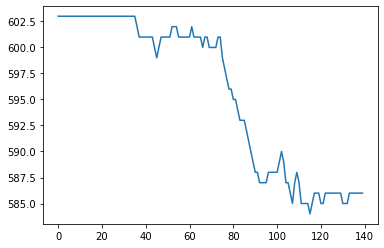

In [8]:
# test_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.05, 0.0000001, 0.0000001, 165, 165, 0.5, 0.5, 0.5, 1.009, 1.009,1.009, 5000]))

test_theta = torch.from_numpy(np.array([0.009, 0.05, 0.33, 1e-6, 165, 165, 500, 5, 1.01, 1.2, 100]))
    
simulated_test = FACTS(test_theta)
x_time = np.linspace(0,500, num=140)
# plt.plot(x_time, simulated_test)
plt.plot(simulated_test)

compensation_adaptive_frame_on 56 24
compensation_adaptive_frame_off 57 25
compensation_adaptive_frame_on 73 41


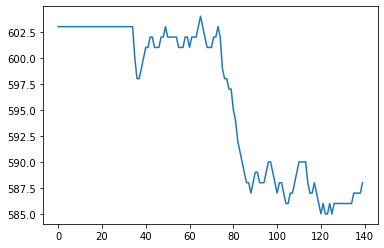

In [9]:
test_theta = torch.from_numpy(np.array([0.009, 0.05, 0.33, 1e-6, 165, 165, 500, 5, 1.01, 1.2, 100]))

simulated_test = FACTS(test_theta)
x_time = np.linspace(0,500, num=140)
plt.plot(simulated_test)

In [ ]:
print(test_theta.shape)

### Run an example trial, or do a parameter sweep

#### 0 Auditory noise scale:

Low: 0.0001

High: 0.04


#### 1 Somatosensory noise scale:

Low: .002

High: 1


#### 2 TSE Process Scale:

Low: 0.0001

High: 5


#### 3 TSE Covariance Scale:

Low: 0.0000001

High: 5

#### 4 ASE Process Scale:

Low: 10e-12

High: 10e-6


#### 5 ASE Covariance Scale:

Low: 10e-12

High: 10e-4


#### 6 SensoryDelay Auditory Delay:

Low: 20

High: 105

#### x7 SensoryDelay Somato Delay:

Low: 45

High: 105

#### x8 TSE estimated_auditory_delay:

Low: 10 

High: 105

#### x9 ASE estimated_somat_delay

Low: 10 

High: 30

#### 10 cc_discount


### Load Parell's data to see what it looks like

In [10]:
# import observed data
data = scipy.io.loadmat('sbi_resources/parrell_2017/parrell_data.mat')

In [11]:
print(data['parrell_data'].dtype)
print(data['parrell_data']['means'][0,0][0,0][0].shape)
print(data['parrell_data']['stds'][0,0][0,0][0].shape)

[('means', 'O'), ('stds', 'O')]
(1, 171)
(1, 171)


### Print some of these data to see what it looks like

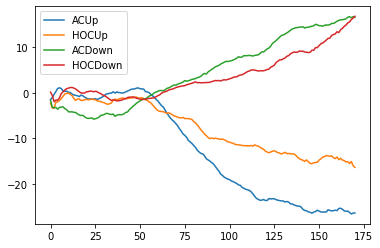

In [12]:
items = ['ACUp', 'HOCUp', 'ACDown', 'HOCDown']

for item in items:
    #pdb.set_trace()
    this_mean = data['parrell_data']['means'][0,0][item][0,0]
    if "Up" in item:
        this_mean = this_mean * -1
    plt.plot(this_mean.T, label=item)
    
plt.legend()

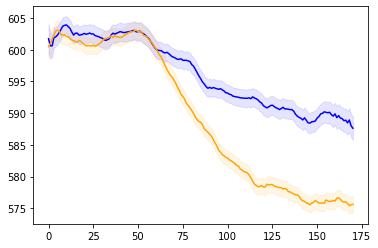

In [13]:
items = ['HOCUp', 'ACUp',]
offset = 603
# offset = 530

# for item in items:
#     #pdb.set_trace()
#     this_mean = data['parrell_data']['means'][0,0][item][0,0]
#     if "Up" in item:
#         this_mean = this_mean * -1 + offset
#     plt.plot(this_mean.T, label=item)
    
# plt.legend()

healthy_mean = data['parrell_data']['means'][0,0]['HOCUp'][0,0][0,:] *-1 +offset +1
cereb_mean = data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:] *-1 +offset -1

plt.plot(healthy_mean, color='blue', label='HC')
plt.plot(cereb_mean, color='orange', label='CD')

cereb_ci = np.abs( data['parrell_data']['stds'][0,0]['ACUp'][0,0][0,:] )
healthy_ci = np.abs(data['parrell_data']['stds'][0,0]['HOCUp'][0,0][0,:] )

plt.fill_between(range(len(cereb_mean)), (cereb_mean-cereb_ci), (cereb_mean+cereb_ci), color='orange', alpha=.1)
plt.fill_between(range(len(healthy_mean)), (healthy_mean-healthy_ci), (healthy_mean+healthy_ci), color='b', alpha=.1)


## Run Simulations and/or Load data

In [30]:
# import facts_for_SBI

load_instead = False



# prior_min= [  0.004, 0.004, .001,  .001,  9e-7,     9e-7, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
# prior_mmax = [0.006, 0.006,  2.5,  .05, 1.1e-6,   1.1e-6, 180, 180,         1,     1,      1,  1.040,  1.040,    1.040,  1e6]

prior_min= [  0.006, 0.01,  .3,      9e-8,     150, 150,       100,         1,      1,           1,    25]
prior_mmax = [ 0.01,  0.6,  2.5,   1.1e-5,    180, 180,      5000,          10,  1.040,      1.15,   1000]

# prior_min= [    0.0,   0.0, 1e-8,  1e-8,  9e-8,     9e-8, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
# prior_mmax = [  1e-4, 1e-4,    1,    1, 1.1e-5,   1.1e-5, 180, 180,     1e10,   1e10,   1e10,      3,      3,       3,   1e6]

num_sim = 50
num_workers = 1

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')
    
# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
for jj in range(1,100):
    print(jj)
    if load_instead == False:    
        try:
            theta, x = simulate_for_sbi(simulator2, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
            #parameter_posterior = infer(simulator2, prior, method='SNPE', num_simulations=num_sim, num_workers=num_workers)
#             density_estimator = inference.append_simulations(theta, x).train()
#             posterior = inference.build_posterior(density_estimator)

        # Save the theta and x
            with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}_local{jj}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([theta, x], f)
        # Save the posterior
#         with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}_local6.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#             pickle.dump([posterior], f)
        except Exception as e:
            print(e)
    
# else:


compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
1


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 102 70
compensation_adaptive_f

compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 4

compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 108 76
compensation_adaptive_frame_on 109 77
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compe

compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
com

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_fra

compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compens

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_frame_off 111 82
compensation_adaptive_f

compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75

compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 52 18
compensation_adaptive_frame_off 53 19
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 123 91
compensa

compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 109 77
compensation_adaptive_frame_on 110 78
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compen

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_

compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 107 73
compensation_adaptive_frame_on 108 74
compensation_adaptive_frame_off 112 78
compensation_adaptive_frame_on 113 79
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 117 83
compensation_adaptive_frame_on 118 84
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compens

compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adapt

compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 113 82
compensation_adaptive_frame_on 114 83
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off

compensation_adaptive_frame_on 73 40
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 99 65
compensati

compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compen

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 105 73
compensation_adaptiv

compensation_adaptive_frame_off 101 72
compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
5


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 47 14
compensation_adaptive_frame_off 48 15
compensation_adaptive_frame_on 56 23
compensation_adaptive_frame_off 57 24
compensation_adaptive_frame_on 64 31
compensation_adaptive_frame_off 65 32
compensation_adaptive_frame_on 73 40
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptiv

compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on

compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 106 75
compensation_adaptive_frame_on 107 76
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptiv

compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 133 101
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_fra

compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 107 73
compensation_adaptive_frame_on 108 74
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_ada

compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compens

compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 112 81
compensation_adaptiv

compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 85 51
c

compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compens

compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 

compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 79 47
compensation_adap

compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 112 82
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 33 3
compensatio

compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132

compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compe

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_fra

compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 108 78
compensation_adaptive_frame_on 109 79
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 112 82
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 13

compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 117 83
compensation_adaptive_frame_on 118 84
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensati

compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 110 77
compensation_adaptive_frame_on 111 78
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation

compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 114 84
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 109 78
compensation_adaptive_frame_on 110 79
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122 9

compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation

compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 107 75
compensation_adaptive_frame_on 108 76
compensation_adaptive_frame_off 109 77
compensation_ad

compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_on 32 2
compensation_adaptive_frame_off 34 4
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_fram

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation

compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 131 97
compens

compensation_adaptive_frame_on 104 75
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off

compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 125 96
compensation_a

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 110 77
compensation_adap

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 94 63
compensati

compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adapti

compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 96

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 95 64
compensation_ada

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 70

compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 109 78
compensation_adapt

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_fra

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compen

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_ada

compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 129 95
comp

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 113 82
compensation_adaptive_frame_on 114 83
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensa

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive

compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compe

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptiv

compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_

compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 110 78
compensation_adaptive_frame_on 111 79
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compens

compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 114 81
compensation_ada

compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 114 81
compensation_adaptive_frame_on 115 82
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 37 7
compensation_adaptive_frame_off 38 8
compensation_adaptive_frame_on 41 11
compensation_adaptive_frame_off 42 12
compensation_adaptive_frame_on 44 14
compensation_adaptive_frame_off 46 16
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 98 69
compensation_adaptive_fra

compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 

compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 106 75
compensation_adaptive_frame_on 107 76
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compe

compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_fra

compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensatio

compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensa

compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 55 26
compensation_adaptive_frame_off 56 27
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_fra

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive

compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
c

compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 137 103
compensation_adaptive_fram

compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 81 

compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 81 52
compensat

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 101 72
compensation_adaptive_fr

compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compen

compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 44 12
compensation_adaptive_frame_off 45 13
compensation_adaptive_frame_on 51 19
compensation_adaptive_frame_off 53 21
compensation_adaptive_frame_on 54 22
compensation_adaptive_frame_off 55 23
compensation_adaptive_frame_on 59 27
compensation_adaptive_frame_off 60 28
compensation_adaptive_frame_on 64 32
compensation_adaptive_frame_off 65 33
compensation_adaptive_frame_on 68 36
compensation_adaptive_frame_off 69 37
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_fram

compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive

compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 99 68
compensatio

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 102 68
compensation_adaptive_

compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 117 85
compensation_ada

compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compe

compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on

compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_fram

compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 101 72
compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 103 74
compensation_adaptive_

compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 48 16
compensation_adaptive_frame_off 49 17
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compen

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 40 7
compensation_adaptive_frame_off 41 8
compensation_adaptive_frame_on 70 37
compensation_adaptive_frame_off 71 38
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensatio

compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 110 78
compensation_adaptive_frame_on 111 79
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96


compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adap

compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptiv

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 33 4
compensation_adaptive_frame_off 34 5
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41

compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive

compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_a

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensatio

compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 75 41
26


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 107 75
compensation_adaptive

compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_a

compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_

compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 34 3
compensation_adaptive_frame_off 35 4
compensation_adaptive_frame_on 43 12
compensation_adaptive_frame_off 44 13
compensation_adaptive_frame_on 52 21
compensation_adaptive_frame_off 53 22
compensation_adaptive_frame_on 54 23
compensation_adaptive_frame_off 55 24
compensation_adaptive_frame_on 65 34
compensation_adaptive_frame_off 66 35
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_on 71 41
compensatio

compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
27


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100

compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 88 59
comp

compensation_adaptive_frame_off 118 84
compensation_adaptive_frame_on 119 85
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adapt

compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_on 36 4
compensation_adaptive_frame_off 37 5
compensation_adaptive_frame_on 61 29
compensation_adaptive_frame_off 62 30
compensation_adaptive_frame_on 73 41
compens

compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 107 73
compensation_a

compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 

compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
c

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compen

compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation

compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adap

compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_on 37 6
compensation_adaptive_frame_off 38 7
compensation_adaptive_frame_on 55 24
compensation_adaptive_frame_off 56 25
compensation_adaptive_frame_on 65 34
compensation_adaptive_frame_off 66 35
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_on 73 41
compensation_adaptiv

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 108 76
compensation_adaptive_frame_on 109 77
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_fram

compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adapti

compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 99 65
compensation_adaptive_frame_on 100 66
compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 112 78
compensation_adaptive_frame_on 113 79
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 119 85
compensation_adaptive_frame_on 120 86
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compen

compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 41 12
compensation_adaptive_frame_off 42 13
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compens

compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 121 88
compe

compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 117 83
compensation_adaptive_frame_on 118 84
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 34 4
compensation_adaptive_frame_off 35 5
compensation_adaptive_frame_on 39 9
compensation_adaptive_frame_off 40 10
compensation_adaptive_frame_on 48 18
compensation_adaptive_frame_off 49 19
compensation_adaptive_frame_on 67 37
compensation_adaptive_frame_off 68 38
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation

compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptiv

compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 108 78
compensation_adaptive_frame_on 109 79
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 112 82
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 114 84
compensation_ada

compensation_adaptive_frame_off 101 72
compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 104 75
compensation_adaptive_frame_on 105 76
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 96 63
c

compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
33


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 97 68
compensation_adaptive_fra

compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 102 72
compensation_adaptive_frame_on 103 73
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 108 78
compensation_adaptive_frame_on 109 79
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
co

compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_on 36 5
compensation_adaptive_frame_off 37 6
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensatio

compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 4

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_fram

compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensatio

compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 89 58
compensa

compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
35


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 107 75
compensation_adapt

compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compe

compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52

compensation_adaptive_frame_on 45 16
compensation_adaptive_frame_off 46 17
compensation_adaptive_frame_on 49 20
compensation_adaptive_frame_off 50 21
compensation_adaptive_frame_on 55 26
compensation_adaptive_frame_off 56 27
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 31 2
compensation_adaptive_frame_off 32 3
compensation_adaptive_frame_on 33 4
compensation_adaptive_frame_off 34 5
compensation_adaptive_frame_on 35 6
compensation_adaptive_frame_off 37 8
compensation_adaptive_frame_on 38 9
compensation_adaptive_frame_off 41 12
compensation_adaptive_frame_on 43 14
compensation_adaptive_frame_off 45 16
compensation_adaptive_frame_on 46 17
compensation_adaptive_frame_off 47 18
compensation_adaptive_frame_on 52 23
compensation_adaptive_frame_off 53 24
compensation_adaptive_frame_on 61 32
compensation_adaptive_frame_off 62 33
compensation_adaptive_frame_on 66 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 109 78
compensation_adapt

compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 102 73
compensation_adaptive_frame_on 103 74
compensation_adaptive_frame_off 109 80
compensati

compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
compensation_adaptive_frame_off 114 81
compensation_adaptive_frame_on 115 82
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 

compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 86 55
comp

compensation_adaptive_frame_off 107 73
compensation_adaptive_frame_on 108 74
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compe

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adap

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 118 84
compensation_adaptive_frame_on 119 85
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 138 104
com

compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compe

compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compe

compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptiv

compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 108 76
compensation_adaptive_frame_on 109 77
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 55 22
compensation_adaptive_frame_off 56 23
compensation_adaptive_frame_on 63 30
compensation_adaptive_frame_off 64 31
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensa

compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 112 82
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 129 96
compensation_adap

compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adapt

compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 108 76
compensation_adaptive_frame_on 109 77
compensation_adaptive_frame_off 110 78
compensation_adaptive_frame_on 111 79
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 1

compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
40


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 112 83
compensation_adaptive_

compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 

compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compens

compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 38 8
compensation_adaptive_frame_off 39 9
compensation_adaptive_frame_on 49 19
compensation_adaptive_frame_off 50 20
compensation_adaptive_frame_on 59 29
compensation_adaptive_frame_off 60 30
compensation_adaptive_frame_on 67 37
compensation_adaptive_frame_off 68 38
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame

compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_on 43 10
compensation_adaptive_frame_off 44 11
compensation_adaptive_frame_on 52 19
compensation_adaptive_frame_off 54 21
compensation_adaptive_frame_on 56 23
compensation_adaptive_frame_off 57 24
compensation_adaptive_frame_on 62 29
compensation_adaptive_frame_off 64 31
compensation_adaptive_frame_on 66 33
compensation_adaptive_frame_off 67 34
compensation_adaptive_frame_on 72 39
compensation_adaptive_frame_off 73 40
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_fr

compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
comp

compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
comp

compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 119 88
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 43 9
compensation_adaptive_frame_off 44 10
compensation_adaptive_frame_on 51 17
compensation_adaptive_frame_off 52 18
compensation_adaptive_frame_on 60 26
compensation_adaptive_frame_off 61 27
compensation_adaptive_frame_on 64 30
compensation_adaptive_frame_off 65 31
compensation_adaptive_frame_on 72 38
compensation_adaptive_frame_off 73 39
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame

compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 39 6
compensation_adaptive_frame_off 40 7
compensation_adaptive_frame_on 62 29
compensation_adaptive_frame_off 63 30
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_on 75 41
compe

compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_

compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 107 73
compensation_adaptive_frame_on 108 74
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 115 81
compensation_a

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_

compensation_adaptive_frame_off 64 34
compensation_adaptive_frame_on 65 35
compensation_adaptive_frame_off 66 36
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_fr

compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adapt

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 114 83
compensation_adapt

compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 1

compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_

compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 38 4
compensation_adaptive_frame_off 39 5
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_

compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 1

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 94 61
compensation_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 36 2
compensation_adaptive_frame_off 37 3
compensation_adaptive_frame_on 40 6
compensation_adaptive_frame_off 41 7
compensation_adaptive_frame_on 44 10
compensation_adaptive_frame_off 45 11
compensation_adaptive_frame_on 55 21
compensation_adaptive_frame_off 56 22
compensation_adaptive_frame_on 64 30
compensation_adaptive_frame_off 65 31
compensation_adaptive_frame_on 69 35
compensation_adaptive_frame_off 70 36
compensation_adaptive_frame_on 71 37
compensation_adaptive_frame_off 72 38
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_of

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_on 75 41
compensation_adaptiv

compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 106 75
compensation_adaptive_frame_on 107 76
compensation_adaptive_frame_off 108 77
compensation_adaptive_frame_on 109 78
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
compensation_adaptive_frame_off 116 85
compensati

compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 114 81
compensation_adaptive_frame_on 115 82
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 103 69


compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_

compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensati

compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compe

compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
compensation_adaptive_frame_off 116 83
compensation_ada

compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 

compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 99 65
compensation_adaptive_frame_on 100 66
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensatio

compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
com

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_on 7

compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
compensation_adaptive_frame_off 99 65
compensation_adaptive_frame_on 100 66
compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 101 67
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_fram

compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 95 63
compensation_ada

compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compens

compensation_adaptive_frame_off 54 24
compensation_adaptive_frame_on 59 29
compensation_adaptive_frame_off 60 30
compensation_adaptive_frame_on 63 33
compensation_adaptive_frame_off 65 35
compensation_adaptive_frame_on 66 36
compensation_adaptive_frame_off 67 37
compensation_adaptive_frame_on 68 38
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_fra

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 112 83
compensation_adaptive_frame_on 113 84
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135

compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_ad

compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_a

compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 10

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame

compensation_adaptive_frame_off 101 72
compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 1

compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compens

compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adapti

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 108 76
compensation_adaptive_frame_on 109 77
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adapt

compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 76 47
co

compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame

compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
54


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 120 91
compensation_adaptive_frame_on 121 92
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 1

compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 120 88
co

compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
compensation_adap

compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
55


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 110 81
compensation_adaptive_

compensation_adaptive_frame_on 120 86
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 114 81
compensation_adaptive_frame_on 115 82
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
co

compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 103 74
compensation_adaptive_frame_on 104 75
compensation_adaptive_frame_off 107 78
compensation_adaptive_

compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 112 78
compensation_adaptive_frame_on 113 79
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 118 84
compensation_adaptive_frame_on 119 85
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 10

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 46 13
compensation_adaptive_frame_off 47 14
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 52 23
compensation_adaptive_frame_off 53 24
compensation_adaptive_frame_on 54 25
compensation_adaptive_frame_off 55 26
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensati

compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 101 72
compensation_adaptive_frame_on 102 73
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 112 83
compensation_adaptive_frame_on 113 84
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_ad

compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 36 3
compensation_adaptive_frame_off 37 4
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 51 17
compensation_adaptive_frame_off 52 18
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_fra

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_fr

compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_

compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 103 74
compensation_adaptive_frame_on 104 75
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensati

compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
c

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive

compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_fram

compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adapti

compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 13

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54


compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 33 4
compensation_adaptive_frame_off 34 5
compensation_adaptive_frame_on 47 18
compensation_adaptive_frame_off 48 19
compensation_adaptive_frame_on 52 23
compensation_adaptive_frame_off 53 24
compensation_adaptive_frame_on 55 26
compensation_adaptive_frame_off 57 28
compensation_adaptive_frame_on 63 34
compensation_adaptive_frame_off 64 35
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compens

compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compens

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_fram

compensation_adaptive_frame_on 36 2
compensation_adaptive_frame_off 37 3
compensation_adaptive_frame_on 43 9
compensation_adaptive_frame_off 44 10
compensation_adaptive_frame_on 47 13
compensation_adaptive_frame_off 48 14
compensation_adaptive_frame_on 52 18
compensation_adaptive_frame_off 53 19
compensation_adaptive_frame_on 54 20
compensation_adaptive_frame_off 55 21
compensation_adaptive_frame_on 68 34
compensation_adaptive_frame_off 69 35
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 120 86
compensation_adaptive_frame_on 121 87
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptiv

compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 108 78
compensation_adaptive_f

compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_on 47 15
compensation_adaptive_frame_off 48 16
compensation_adaptive_frame_on 59 27
compensation_adaptive_frame_off 60 28
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_on 57 23
compensation_adaptive_frame_off 58 24
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_on 71 41
compensation_adap

compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adapti

compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 111 80
compensation_adaptive_frame_on 112 81
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
c

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 3

compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 108 77
compensation_adaptive_frame_on 109 78
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compe

compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 76 45
compen

compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 108 78
compensation_adaptive_frame_on 109 79
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 89 56
compensation_adapt

compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 114 81
com

compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 129 99
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_

compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 112 78
compensation_adaptive_frame_on 113 79
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
co

compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 104 70
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 55 23
compensation_adaptive_frame_off 56 24
compensation_adaptive_frame_on 57 25
compensation_adaptive_frame_off 58 26
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 81 51
compensation_ada

compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 1

compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 110 77
compensation_adaptive_frame_on 111 78
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 50 16
compensation_adaptive_frame_off 51 17
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_f

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 1

compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 10

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 101 69
compensation_adaptive_fr

compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 123 94
compe

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 35 6
compensation_adaptive_frame_off 36 7
compensation_adaptive_frame_on 38 9
compensation_adaptive_frame_off 39 10
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off

compensation_adaptive_frame_on 69 35
compensation_adaptive_frame_off 70 36
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_fram

compensation_adaptive_frame_off 119 85
compensation_adaptive_frame_on 120 86
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 13

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 75 41
compensation_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_on 75 41
compensation_a

compensation_adaptive_frame_off 109 77
compensation_adaptive_frame_on 110 78
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 1

compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
c

compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adapt

compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 107 75
compensation_adaptive_frame_on 108 76
compensation_adaptive_frame_off 109 77
compensation_adaptive_frame_on 110 78
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compe

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 85 52
compensation

compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_a

compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 108 78
compensation_adaptive_frame_on 109 79
compensation_adaptiv

compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_fra

compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensat

compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptiv

compensation_adaptive_frame_on 35 3
compensation_adaptive_frame_off 37 5
compensation_adaptive_frame_on 63 31
compensation_adaptive_frame_off 64 32
compensation_adaptive_frame_on 71 39
compensation_adaptive_frame_off 72 40
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 104 75
compensation_adaptive_frame_on 105 76
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
c

compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_on 32 2
compensation_adaptive_frame_off 33 3
compensation_adaptive_frame_on 39 9
compensation_adaptive_frame_off 40 10
compensation_adaptive_frame_on 46 16
compensation_adaptive_frame_off 47 17
compensation_adaptive_frame_on 49 19
compensation_adaptive_frame_off 50 20
compensation_adaptive_frame_on 53 23
compensation_adaptive_frame_off 54 24
compensation_adaptive_frame_on 56 26
compensation_adaptive_frame_off 57 27
compensation_adaptive_frame_on 58 28
compensation_adaptive_frame_off 61 31
compensation_adaptive_frame_on 63 33
compensation_a

compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensatio

compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 71 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 92 60
co

compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_ada

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 

compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
co

compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 45 11
compensation_adaptive_frame_off 46 12
compensation_adaptive_frame_on 55 21
compensation_adaptive_frame_off 58 24
compensation_adaptive_frame_on 59 25
compensation_adaptive_frame_off 60 26
compensation_adaptive_frame_on 69 35
compensation_adaptive_frame_off 70 36
com

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 1

compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 121 90
compensation_adap

compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptiv

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 87 56
compensation_adaptive_frame_on 88 57
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 114 83
compensation_adaptiv

compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_fr

compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_off 107 73
compensation_adaptive_frame_on 108 74
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 118 84
compensation_adaptive_frame_on 119 85
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_off 139

compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 99 65
compensation_adaptive_frame_on 100 66
compensation_adaptive_frame_off 101 67
compensation_adaptive_frame_on 102 68
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 111 77
compensation_adaptive_frame_on 112 78
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
compensation_adaptive_frame_off 117 83
compensation_adaptive_frame_on 118 84
compensation_adaptive_frame_off 119 85
compensation_adaptive_frame_on 120 86
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 128 94
compensation_adaptive_frame_on 129 95
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42

compensation_adaptive_frame_on 42 13
compensation_adaptive_frame_off 43 14
compensation_adaptive_frame_on 54 25
compensation_adaptive_frame_off 55 26
compensation_adaptive_frame_on 61 32
compensation_adaptive_frame_off 62 33
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 83 50
compensati

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_frame_off 92 58
compensation_adaptive_frame_on 93 59
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
compensation_adaptive_frame_off 124 90
compensation_ada

compensation_adaptive_frame_off 110 77
compensation_adaptive_frame_on 111 78
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 8

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation

compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 5

compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 105 72
compensation_adaptive_frame_on 106 73
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 110 77
compensation_adaptive_frame_on 111 78
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 135 1

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_

compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 

compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45


compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 106 75
compensation_adaptive_frame_on 107 76
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_a

compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame

compensation_adaptive_frame_on 111 79
compensation_adaptive_frame_off 112 80
compensation_adaptive_frame_on 113 81
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54

compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 112 82
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 130 100


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 103 71
compensation_adapti

compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 42 8
compensation_adaptive_frame_off 43 9
compensation_adaptive_frame_on 52 18
compensation_adaptive_frame_off 53 19
compensation_adaptive_frame_on 60 26
compensation_adaptive_frame_off 61 27
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_a

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 99 69
compensation_adaptive_frame_on 100 70
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensatio

compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 117 84
compensation_ad

compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 134 101

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 136 10

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 112 78
compensation_adaptive_f

compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_

compensation_adaptive_frame_on 90 59
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 111 80
compensation_adaptive_frame_on 112 81
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
comp

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptiv

compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_

compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
comp

compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 108 77
compensation_adaptive_frame_on 109 78
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 79 48
compensation_adaptiv

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adapti

compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 78 45
compensation_adaptive_frame_on 79 46
compensation_adaptive_frame_off 80 47
compensation_adaptive_frame_on 81 48
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55

compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 64 32
compensation_adaptive_frame_off 65 33
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 108 74
compensation_adaptive_frame_on 109 75
compensation_adaptive_frame_off 114 80
compensation_adaptive_frame_on 115 81
compensation_adaptive_frame_off 119 85
compensation_adaptive_frame_on 120 86
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 131 97
com

compensation_adaptive_frame_on 41 11
compensation_adaptive_frame_off 42 12
compensation_adaptive_frame_on 45 15
compensation_adaptive_frame_off 48 18
compensation_adaptive_frame_on 51 21
compensation_adaptive_frame_off 52 22
compensation_adaptive_frame_on 57 27
compensation_adaptive_frame_off 58 28
compensation_adaptive_frame_on 68 38
compensation_adaptive_frame_off 69 39
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 83 49
compensation_adaptive_frame_on 84 50
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 89 55
compensation_adaptive_frame_on 90 56
compensation_adaptive_fram

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_off 1

compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 96 62
compensation_adaptive_frame_on 97 63
compensation_adaptive_frame_off 102 68
compensation_adaptive_frame_on 103 69
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 37 4
compensation_adaptive_frame_off 39 6
compensation_adaptive_frame_on 43 10
compensation_adaptive_frame_off 44 11
compensation_adaptive_frame_on 52 19
compensation_adaptive_frame_off 53 20
compensation_a

compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_fram

compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 127 94
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame

compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_on 71 41
84


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
compensation_adaptive_frame_off 93 62
compensation_adaptive_frame_on 94 63
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_fra

compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 109 78
compensation_adaptive_frame_on 110 79
compensation_adaptive_frame_off 111 80
compensation_adaptive_frame_on 112 81
compensation_adaptive_frame_off 113 82
compensation_adaptive_frame_on 114 83
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
co

compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_off 104 74
compensation_adaptive_frame_on 105 75
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 71 41
compen

compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_off 108 77
compensation_adaptive_frame_on 109 78
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
c

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adapti

compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_off 108 79
compensation_adaptive_frame_on 109 80
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 112 83
compensation_adaptive_frame_on 113 84
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 11

compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
co

compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
c

compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
comp

compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 94 63
compensation_adaptive_frame_on 95 64
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 109 78
compensation_adaptive_frame_on 110 79
compensation_adaptive_frame_off 113 82
compensation_adaptive_frame_on 114 83
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 124 93
compe

compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_fram

compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 132 102
compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 134 104
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80

compensation_adaptive_frame_off 106 72
compensation_adaptive_frame_on 107 73
compensation_adaptive_frame_off 113 79
compensation_adaptive_frame_on 114 80
compensation_adaptive_frame_off 119 85
compensation_adaptive_frame_on 120 86
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 131 97
compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compen

compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 103 74
compensation_adaptive_frame_on 104 75
compensation_adaptive_frame_off 105 76
compensation_adaptive_frame_on 106 77
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
compensation_adaptive_frame_off 118 89
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compen

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 114 81
compensation_adaptive_frame_on 115 82
compensation_adaptive_frame_off 116 83
compensation_adaptive_frame_on 117 84
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
compensation_adaptive_frame_off 120 87
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 13

compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_frame_on 104 74
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
compens

compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 110 77
compensation_adaptive_frame_on 111 78
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 80 48
com

compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 120 90
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_

compensation_adaptive_frame_off 126 94
compensation_adaptive_frame_on 127 95
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 86 53
compensation_a

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_fram

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 75 42
compensation_adaptive_frame_on 76 43
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
compensation_adaptive_frame_off 107 74
compensation_adaptive_frame_on 108 75
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
comp

compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adapt

compensation_adaptive_frame_off 107 77
compensation_adaptive_frame_on 108 78
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
compensation_adaptive_frame_off 117 87
compensation_adaptive_frame_on 118 88
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76

compensation_adaptive_frame_on 132 98
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 96 67
com

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 99 70
compensation_adaptive_fra

compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 90 59
compensation_adaptive_frame_on 91 60
compensation_ada

compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 55 24
compensation_adaptive_frame_off 56 25
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44


compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_on 40 8
compensation_adaptive_frame_off 41 9
compensation_adaptive_frame_on 48 16
compensation_adaptive_frame_off 49 17
compensation_adaptive_frame_on 53 21
compensation_adaptive_frame_off 54 22
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 76 47
compensation_adaptive_frame_on 77 48
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 93 64
compensation_adaptive_fram

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 79 50
compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 97 68
compensation_adaptive_frame_on 98 69
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
compensation_adaptive_frame_off 117 88
compensation_adaptive_frame_on 118 89
compensation_adaptive_frame_off 121 92
compensation_ad

compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 124 90
compensation_adaptive_frame_on 125 91
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 

compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 81 47
compensation_adaptive_frame_on 82 48
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 93 59
compensation_adaptive_frame_on 94 60
compensation_adaptive_frame_off 95 61
compensation_adaptive_frame_on 96 62
compen

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 91 62
compensation_adaptive_frame_on 92 63
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compen

compensation_adaptive_frame_off 57 24
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 85 53
compensation_adaptive_frame_on 86 54
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 75 41


compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 97 63
compensation_adaptive_frame_on 98 64
compensation_adaptive_frame_off 103 69
compensation_adaptive_frame_on 104 70
compensation_adaptive_frame_off 105 71
compensation_adaptive_frame_on 106 72
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 83 53
compensation_ad

compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 128 98
compensation_adaptive_frame_on 129 99
93


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 44 11
compensation_adaptive_frame_off 45 12
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 76 45
compensation_adaptive_frame_on 77 46
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
compensation_adaptive_frame_off 80 49
compensation_adaptive_frame_on 81 50
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
compensation_ada

compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_of

compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
compensation_adaptive_frame_off 87 53
compensation_adaptive_frame_on 88 54
compensation_adapt

compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 139 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_fr

compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 73 42
compensation_adaptive_frame_on 74 43
compensation_adaptive_frame_off 75 44
compensation_adaptive_frame_on 76 45
compensation_adaptive_frame_off 77 46
compensation_adaptive_frame_on 78 47
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_

compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 

compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 76 44
compensation_adaptive_frame_on 77 45
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 80 48
compensation_adaptive_frame_on 81 49
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 103 71
compensation_adaptive_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 81 51
compensation_adaptive_frame_on 82 52
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 105 75
compensation_adaptive_frame_on 106 76
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105


compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensati

compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 71 42
compensation_adaptive_frame_on 72 43
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 82 53
compensation_adaptive_frame_on 83 54
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_fr

compensation_adaptive_frame_on 74 41
96


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 76 42
compensation_adaptive_frame_on 77 43
compensation_adaptive_frame_off 78 44
compensation_adaptive_frame_on 79 45
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 86 52
compensation_adaptive_frame_on 87 53
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 98 64
compensation_adaptive_frame_on 99 65
compensation_adaptive_frame_off 100 66
compensation_adaptive_frame_on 101 67
compensation_adaptive_fram

compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 97 65
compensation_adaptive_frame_on 98 66
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 107 75
compensation_adaptive_frame_on 108 76
compensation_adapt

compensation_adaptive_frame_on 78 46
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 110 78
compensation_adaptive_frame_on 111 79
compensation_adaptive_frame_off 114 82
compensation_adaptive_frame_on 115 83
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
compensati

compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_frame_on 70 41
97


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 74 44
compensation_adaptive_frame_on 75 45
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 100 70
compensation_adaptive_frame_on 101 71
compensation_adaptive_frame_off 103 73
compensation_adaptive_

compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 109 78
compensation_adaptive_frame_on 110 79
compensation_adaptive_frame_off 113 82
compensation_adaptive_frame_on 114 83
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 

compensation_adaptive_frame_on 104 72
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
compensation_adaptive_frame_off 107 75
compensation_adaptive_frame_on 108 76
compensation_adaptive_frame_off 109 77
compensation_adaptive_frame_on 110 78
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 117 85
compensation_adaptive_frame_on 118 86
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 134 

compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 99 66
compensation_adaptive_frame_on 100 67
compensation_adaptive_frame_off 102 69
compensation_adaptive_frame_on 103 70
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
compensation_adaptive_frame_off 109 76
compensation_adaptive_frame_on 110 77
compensation_adaptive_frame_off 111 78
compensation_adaptive_frame_on 112 79
compensation_adaptive_frame_off 113 80
compensation_adaptive_frame_on 114 81
compensation_adaptive_frame_off 115 82
compensation_adaptive_frame_on 116 83
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
compen

compensation_adaptive_frame_on 80 51
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 85 56
compensation_adaptive_frame_on 86 57
compensation_adaptive_frame_off 88 59
compensation_adaptive_frame_on 89 60
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 94 65
compensation_adaptive_frame_on 95 66
compensation_adaptive_frame_off 96 67
compensation_adaptive_frame_on 97 68
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 113 84
compensation_adapt

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 139 105
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 122 88
compensation_adaptive_frame_on 123 89
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adapti

compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
compensation_adaptive_frame_off 107 75
compensation_adaptive_frame_on 108 76
compensation_adaptive_frame_off 109 77
compensation_adaptive_frame_on 110 78
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 115 83
compensati

compensation_adaptive_frame_on 68 34
compensation_adaptive_frame_off 69 35
compensation_adaptive_frame_on 71 37
compensation_adaptive_frame_off 72 38
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 74 42
compensation_adaptive_frame_on 75 43
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
compensation_adaptive_frame_off 95 63
compensation_adaptive_frame_on 96 64
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive

compensation_adaptive_frame_on 100 69
compensation_adaptive_frame_off 105 74
compensation_adaptive_frame_on 106 75
compensation_adaptive_frame_off 107 76
compensation_adaptive_frame_on 108 77
compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 73 41
99


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
compensation_adaptive_frame_off 86 56
compensation_adaptive_frame_on 87 57
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensati

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 115 84
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 117 86
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 1

compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 78 48
compensation_adaptive_frame_on 79 49
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
compensation_adaptive_frame_off 95 65
compensation_adaptive_frame_on 96 66
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adap

compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
compensation_adaptive_frame_off 129 99
compensation_adaptive_frame_on 130 100
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 137 107
compensation_adaptive_frame_on 138 108
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame

compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 93 63
compensation_adaptive_frame_on 94 64
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
compensation_adaptive_frame_off 88 59
compensation_adaptive_fram

## Load theta and x

In [31]:
# Get list of all pickle files matching string
# all_files = os.listdir('./sbi_resources')
path_to_files = './sbi_resources/'
all_files = os.listdir(path_to_files) 
selected_files = [x for x in all_files if 'theta_x_' in x]
# selected_files = [x for x in all_files if 'theta_x_' in x and 'local' in x]


# Iterate through list
all_theta, all_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
for file_string in selected_files:
    file = open(f'{path_to_files}{file_string}', 'rb')
#     pdb.set_trace()
    this_theta, this_x = pickle.load(file)

    # Append 
    all_theta = torch.cat((all_theta, this_theta))
    all_x = torch.cat((all_x, this_x))

    # Close file
    file.close()    
print(all_theta.shape)
print(all_x.shape)




torch.Size([16550, 11])
torch.Size([16550, 140])


In [ ]:
# labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
#           'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
#           'Auditory Delay', 'Somato Delay', 'AUKF_Qmult_for_pert', 
#           'AUKF_Rmult_for_pert', 'AUKF_Pmult_for_pert', 'AUKF_learning_rate']


# print(labels[-6])
# filter_some_data=True
# if filter_some_data == True:
#     filter_bool = all_theta[:,-6] < 180
#     all_x = all_x[filter_bool]
#     all_theta = all_theta[filter_bool]
    
# print('after too large Auditory Delay filter')
# print(all_theta.shape)
# print(all_x.shape)

# filter_data_on_magnitude=True
# if filter_data_on_magnitude == True:
#     filter_bool = torch.any(all_x < 498, dim=1)
#     all_x = all_x[~filter_bool]
#     all_theta = all_theta[~filter_bool]
    
# print('after magnitude filter')
# print(all_theta.shape)
# print(all_x.shape)

In [32]:
filter_some_data=True
if filter_some_data == True:
    filter_bool2 = (all_x != -1).all(axis=1)
    all_x = all_x[filter_bool2]
    all_theta = all_theta[filter_bool2]
  
print('after negative filter')
print(all_theta.shape)
print(all_x.shape)

after negative filter
torch.Size([16550, 11])
torch.Size([16550, 140])


### Resample cereb data so that it resamples to 5ms to match FACTS

In [33]:
from scipy.interpolate import interp1d
###Downsample data to match simulator output 
def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

cereb_mean_ds = downsample(cereb_mean, 100)
healthy_mean_ds = downsample(healthy_mean, 100)

cereb_ci_ds = downsample(cereb_ci, 100)
healthy_ci_ds = downsample(healthy_ci, 100)

print(cereb_mean_ds.shape)

(100,)


### Create simulated data of preonset

The first 40 frames appear to have the same unperturbed data

(140,)


(-200.0, 500.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


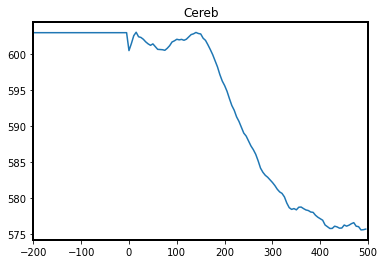

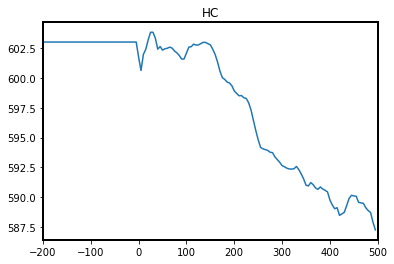

In [34]:
def create_precompensation_synthetic_data(orig_data):
#     precomp_mean = np.mean(orig_data[0:40])
#     precomp_std = np.std(orig_data[0:40])
#     precomp_offset = 530
    precomp_offset = 603

    cereb_synth = np.array([precomp_offset]*40)
    return np.concatenate( (cereb_synth, orig_data) )


cereb_mean_synth = create_precompensation_synthetic_data(cereb_mean_ds)
healthy_mean_synth = create_precompensation_synthetic_data(healthy_mean_ds)
#pdb.set_trace()
x_time = np.arange(-200,500,5)
plt.plot(x_time, cereb_mean_synth )
plt.title('Cereb')
#plt.ylim([500, 535])
plt.xlim([-200,500])

plt.figure()
plt.plot(x_time, healthy_mean_synth )
plt.title('HC')
#plt.ylim([500, 535])
print(healthy_mean_synth.shape)
plt.xlim([-200,500])



### Only grab the first 140 samples to match Ben's data

100 FACTS samples covers 0-500ms

40 FACTS samples covers 200ms preperturbation, which we wont plot

In [35]:
all_x_ds = all_x[:,0:140]
print(all_x_ds.shape)
print(all_theta.shape)
# print(all_x_ds)
# print(all_theta)

torch.Size([16550, 140])
torch.Size([16550, 11])


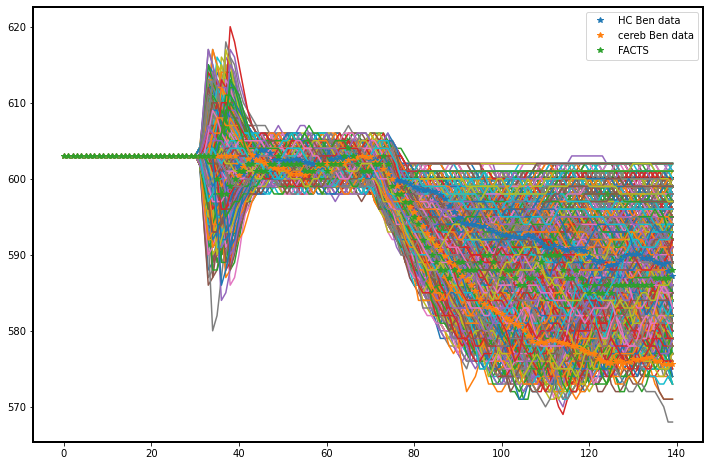

In [36]:
# Print some of the training data, just to make sure it is diverse
sample_size = all_x_ds.shape[0]
n = sample_size
x_time = np.linspace(-200,700, num=140)
x_time_repeated = np.tile(x_time, n).reshape(n, -1)


random_samples_indices = np.random.choice(sample_size, n, replace=False)

plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T)
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )
plt.plot(simulated_test, '*',label='FACTS')

plt.legend()

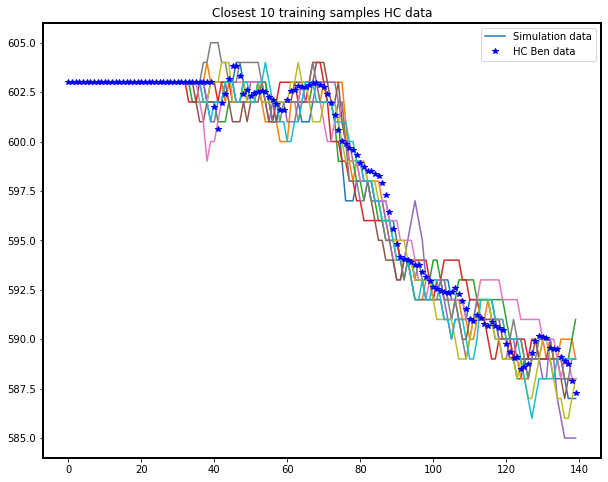

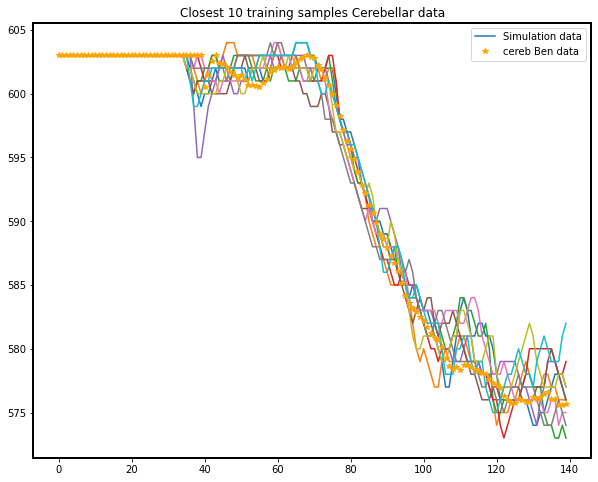

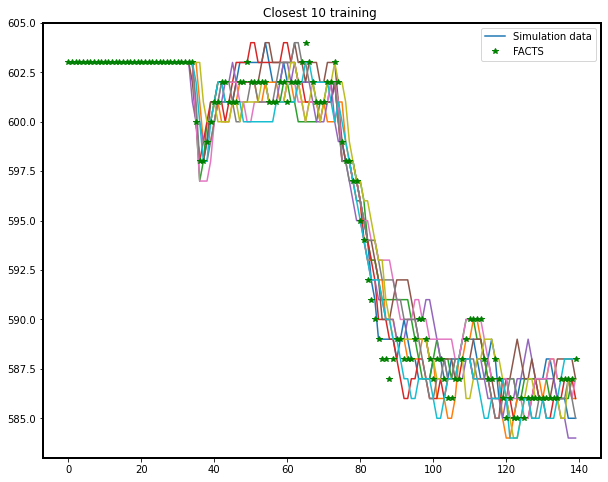

In [37]:
# Show the closest training samples
differencesHC = abs(all_x_ds - healthy_mean_synth)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 10
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

# Plot which lines are closest
differences = abs(all_x_ds - cereb_mean_synth)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

# Sort by sum
differences_FACTS = abs(all_x_ds - simulated_test)
differencesFACTS_summed = torch.sum(differences_FACTS, dim=1)
sorted_tensorF, indicesF = torch.sort(differencesFACTS_summed)

plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesF[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(simulated_test, '*', color='green', label='FACTS' )
plt.title(f'Closest {n} training ')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

(140,)
(140,)


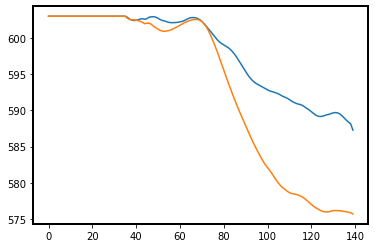

In [38]:
# What if we smooth the cereb_mean_synth and the healthy_mean_synth?

def smooth_np_convolve(data, window_size = 3):
    # Get a pad
    # Pad the data at the edges
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')

    # Define the sliding average window size
    kernel = np.ones(window_size) / window_size

    # Apply the sliding average
    smoothed_data_interior = np.convolve(padded_data, kernel, mode='valid')

    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]
    smoothed_data[-1] = data[-1]
    smoothed_data[1:-1] = smoothed_data_interior[1:-1]
    return smoothed_data

smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
# plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )

plt.plot(smoothed_healthy)
plt.plot(smoothed_cereb)
print(healthy_mean_synth.shape)
print(smoothed_healthy.shape)

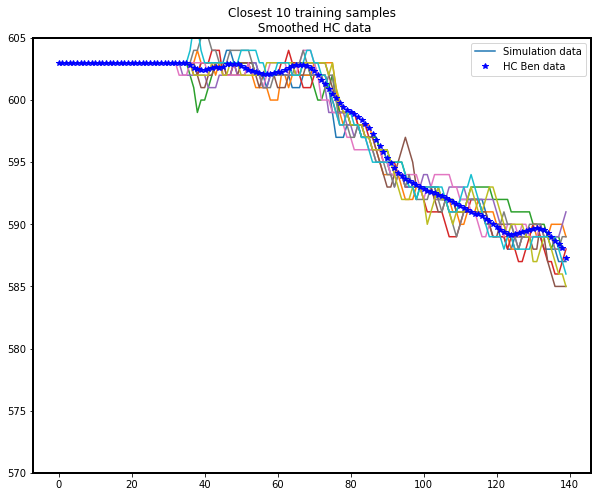

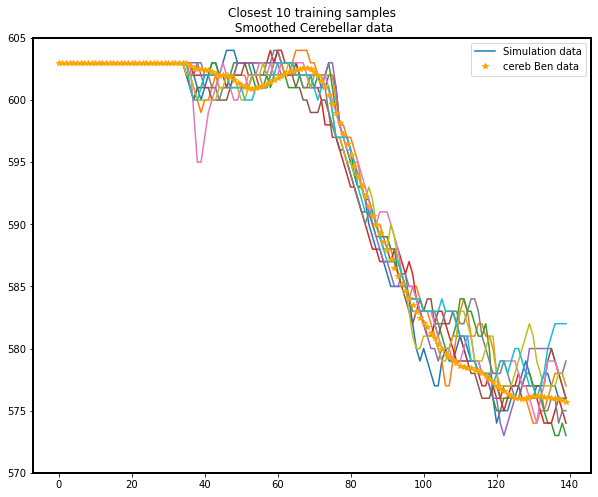

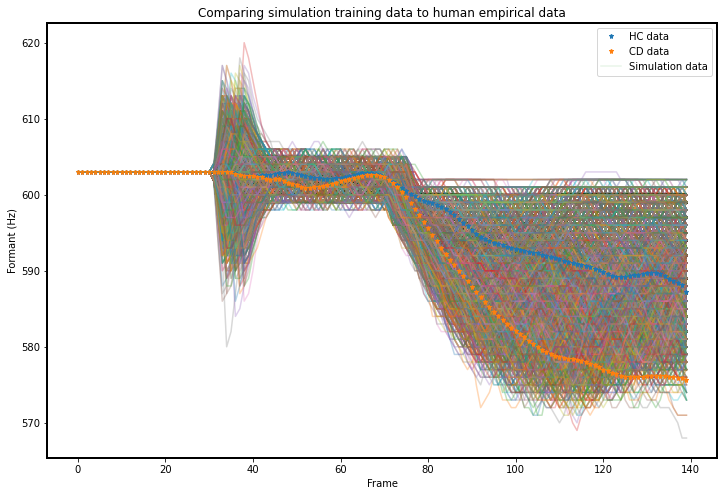

In [39]:
# Show the closest training samples
differencesHC = abs(all_x_ds - smoothed_healthy)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 10
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
plt.plot(smoothed_healthy.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

plt.ylim([570, 605])
# plt.ylim([490, 540])

# Plot which lines are closest
differences = abs(all_x_ds - smoothed_cereb)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(smoothed_cereb.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)
plt.ylim([570, 605])
# plt.ylim([490, 540])

#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T, label='_nolegend_', alpha=0.3)
h1 = plt.plot(smoothed_healthy.reshape(1,140).T, '*', markersize=5, label= 'HC data')
h2 = plt.plot(smoothed_cereb.reshape(1,140).T, '*', markersize=5, label='CD data' )
h3 = plt.plot(all_x_ds[0,:].T, label='Simulation data', alpha=0.1)
plt.title('Comparing simulation training data to human empirical data')
plt.xlabel('Frame')
plt.ylabel('Formant (Hz)')
plt.legend()

Text(0.5, 1.0, 'Differences in HC vs CD F1 Compensation')

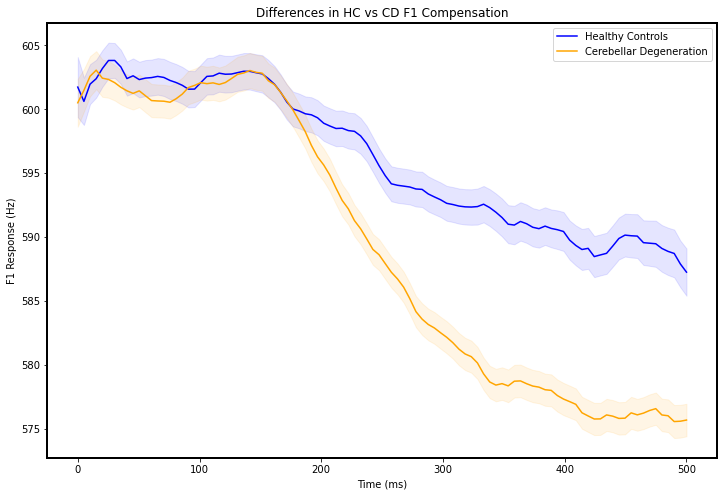

In [40]:
# Plot without empiri
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Differences in HC vs CD F1 Compensation')

(570.0, 606.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


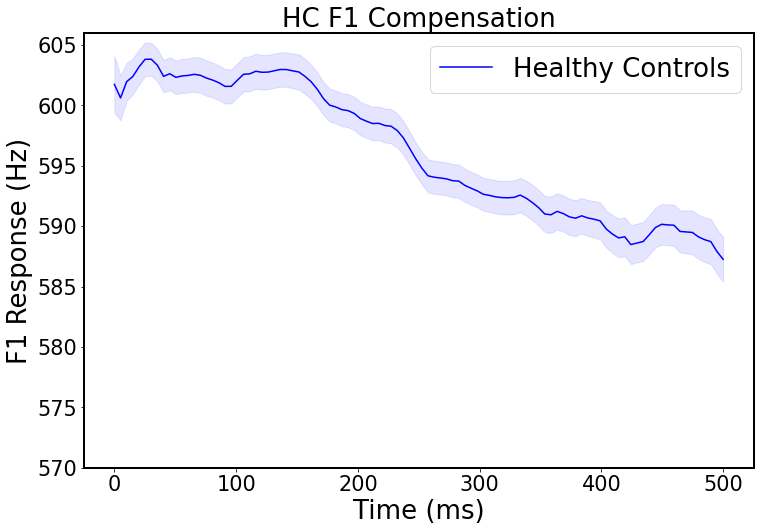

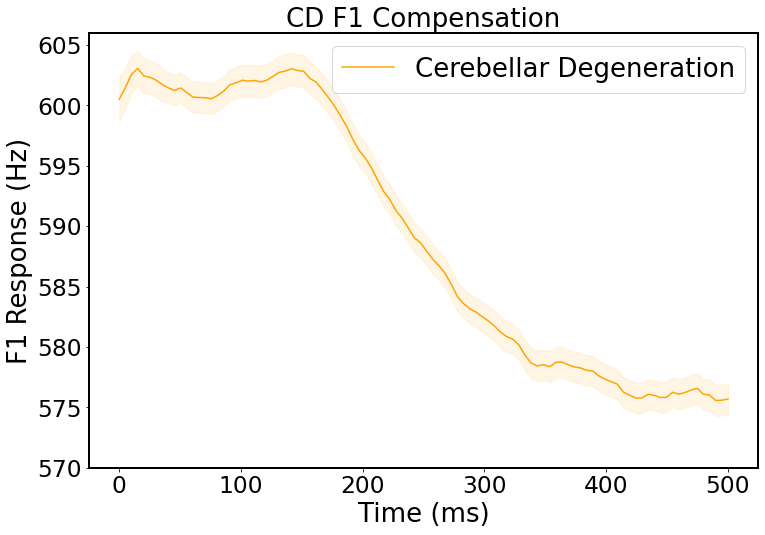

In [41]:


# Plot without empiri
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))

ft_size = 26

plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


# plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
# plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)', fontsize=ft_size,)
plt.ylabel('F1 Response (Hz)', fontsize=ft_size)

plt.legend(fontsize=ft_size)
plt.title('HC F1 Compensation', fontsize=ft_size)


font = {'family' : 'normal',
        'weight' : 'normal',
        }
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.8)
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.ylim([570,606])
# plt.ylim([490,540])



plt.figure(figsize=(12,8))
# plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
# plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)', fontsize=ft_size,)
plt.ylabel('F1 Response (Hz)', fontsize=ft_size,)

plt.legend(fontsize=ft_size)
plt.title('CD F1 Compensation', fontsize=ft_size,)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.9)
plt.ylim([570,606])
# plt.ylim([490,540])

In [42]:

# Replace_all_with_best = False
# if Replace_all_with_best:
#     print(all_x_ds.shape)
#     print(all_theta.shape)

#     print(all_x_ds[indices[0:n]].shape)
#     print(all_x_ds[indicesHC[0:n]].shape)

#     all_x_ds = torch.from_numpy( np.vstack( (all_x_ds[indices[0:n]], all_x_ds[indicesHC[0:n]]) ) )
#     all_theta = torch.from_numpy( np.vstack( (all_theta[indices[0:n]], all_theta[indicesHC[0:n]]) ))
#     print(best_x_ds.shape)
#     print(best_theta.shape)
    
    


# best_N_x = 
# best_N_theta = 

In [44]:

# prior_min= [  0.001, 0.01,  .1,   .01,   9e-8,     9e-8, 150, 150,       100,   1e-17,      1,      1,      1,       1,    25]
# prior_mmax = [ 0.01,  0.1,  2.5,  .05, 1.1e-5,   1.1e-5, 180, 180,      5000,       5,      10,  1.040,  1.040,    1.2,   1000]

prior_min= [  0.006, 0.01,  .3,      9e-8,     150, 150,       100,         1,      1,           1,    25]
prior_mmax = [ 0.01,  0.6,  2.5,   1.1e-5,    180, 180,      5000,          10,  1.040,      1.15,   1000]

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')

run_and_save = True
print(len(prior_min))
# Downsample all_x
if run_and_save:
#     density_estimator = inference.append_simulations(best_theta, best_x_ds).train(force_first_round_loss=True,
    density_estimator = inference.append_simulations(all_theta, all_x_ds).train(force_first_round_loss=True,
                                                                                discard_prior_samples=True, 
                                                                                show_train_summary=True,
                                                                               training_batch_size=32,
                                                                                learning_rate = 5e-5,
                                                                               ) # Look more into force_first_round_loss=True
#     density_estimator = inference.append_simulations(all_theta[0:100000,:], all_x_ds[0:100000]).train(force_first_round_loss=True)
#     posterior = inference.build_posterior(density_estimator, sample_with='mcmc')
    posterior = inference.build_posterior(density_estimator)

    # Save the posterior
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_local_nsf.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([posterior], f)
        
else:
#     with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_72000_local.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_767179_okay.pkl', 'rb') as f:  # Python 3: open(..., 'wb')

#         pdb.set_trace()
        object_file = pickle.load(f)
        posterior = object_file[0]

compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 72 42
compensation_adaptive_frame_on 73 43
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 77 47
compensation_adaptive_frame_on 78 48
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 87 57
compensation_adaptive_frame_on 88 58
compensation_adaptive_frame_off 89 59
compensation_adaptive_frame_on 90 60
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 96 66
compensation_adaptive_frame_on 97 67
compensation_adaptive_frame_off 98 68
compensation_adaptive_frame_on 99 69
compensation_adaptive_fram

In [45]:
# # Save the posterior
print(all_theta.size()[0])
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posterior], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)


16550


/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/sbi/inference/base.py:428: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  "When the inference object is pickled, the behaviour of the loaded object "


In [46]:
# Helper function
def get_modes(data):
    # Initialize list to store modes
    modes = []
    
    # Iterate over each dimension (column) in the data
    for i in range(data.shape[1]):
        kde = stats.gaussian_kde(data[:, i])
        x = np.linspace(data[:, i].min(), data[:, i].max(), 1000)
        mode_x = x[np.argmax(kde.evaluate(x))]
        modes.append(mode_x)
    
    return np.array(modes)

In [ ]:
# labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
#           'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
#           'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE','cc_discount_from_delay_ASE', 
#           'cc_decay', 'cc_minimum']
# labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
#           'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
#           'Auditory Delay', 'Somato Delay', 
#           'AUKF_Rmult_for_pert', 
#           'AUKF_Qmult_for_pert', 
#           'AUKF_Pmult_for_pert', 
#           'AUKF_learning_rate_R',
#          'AUKF_learning_rate_Q',
#          'AUKF_learning_rate_P',
#          'sensory_error_threshold']

## Sample the posterior for the mean of all trials

In [47]:
sample_size = 1000
# sample_size = all_theta.size()[0]

In [48]:
samples_test_FACTS = posterior.sample((sample_size,), x=simulated_test)
# samples_test_FACTS = posterior.sample((702438,), x=simulated_test)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/nflows/transforms/lu.py:81: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2121.)
  outputs.t(), lower, upper=False, unitriangular=True


In [49]:
# samples_cereb = posterior.sample((all_theta.size()[0],), x=cereb_mean_synth)
samples_cereb = posterior.sample((sample_size,), x=cereb_mean_synth)
# samples_cereb = posterior.sample((sample_size,), x=smoothed_cereb)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
# samples_healthy = posterior.sample((all_theta.size()[0],), x=healthy_mean_synth)
samples_healthy = posterior.sample((sample_size,), x=healthy_mean_synth)
# samples_healthy = posterior.sample((sample_size,), x=smoothed_healthy)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# plt.rcParams.update({'font.size': 12})

# #Append test_FACTS
# px_testFACTS = pd.DataFrame(samples_test_FACTS).astype("float")
# display(px_testFACTS)
# px_testFACTS.set_axis(labels, axis="columns", inplace=True)
# px_testFACTS["Group"] = "TestFACTS"

# px2 = px_testFACTS
# g = sns.PairGrid(px2, diag_sharey=False, corner=True)

# g = sns.pairplot(px, corner=True, kind='hist')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

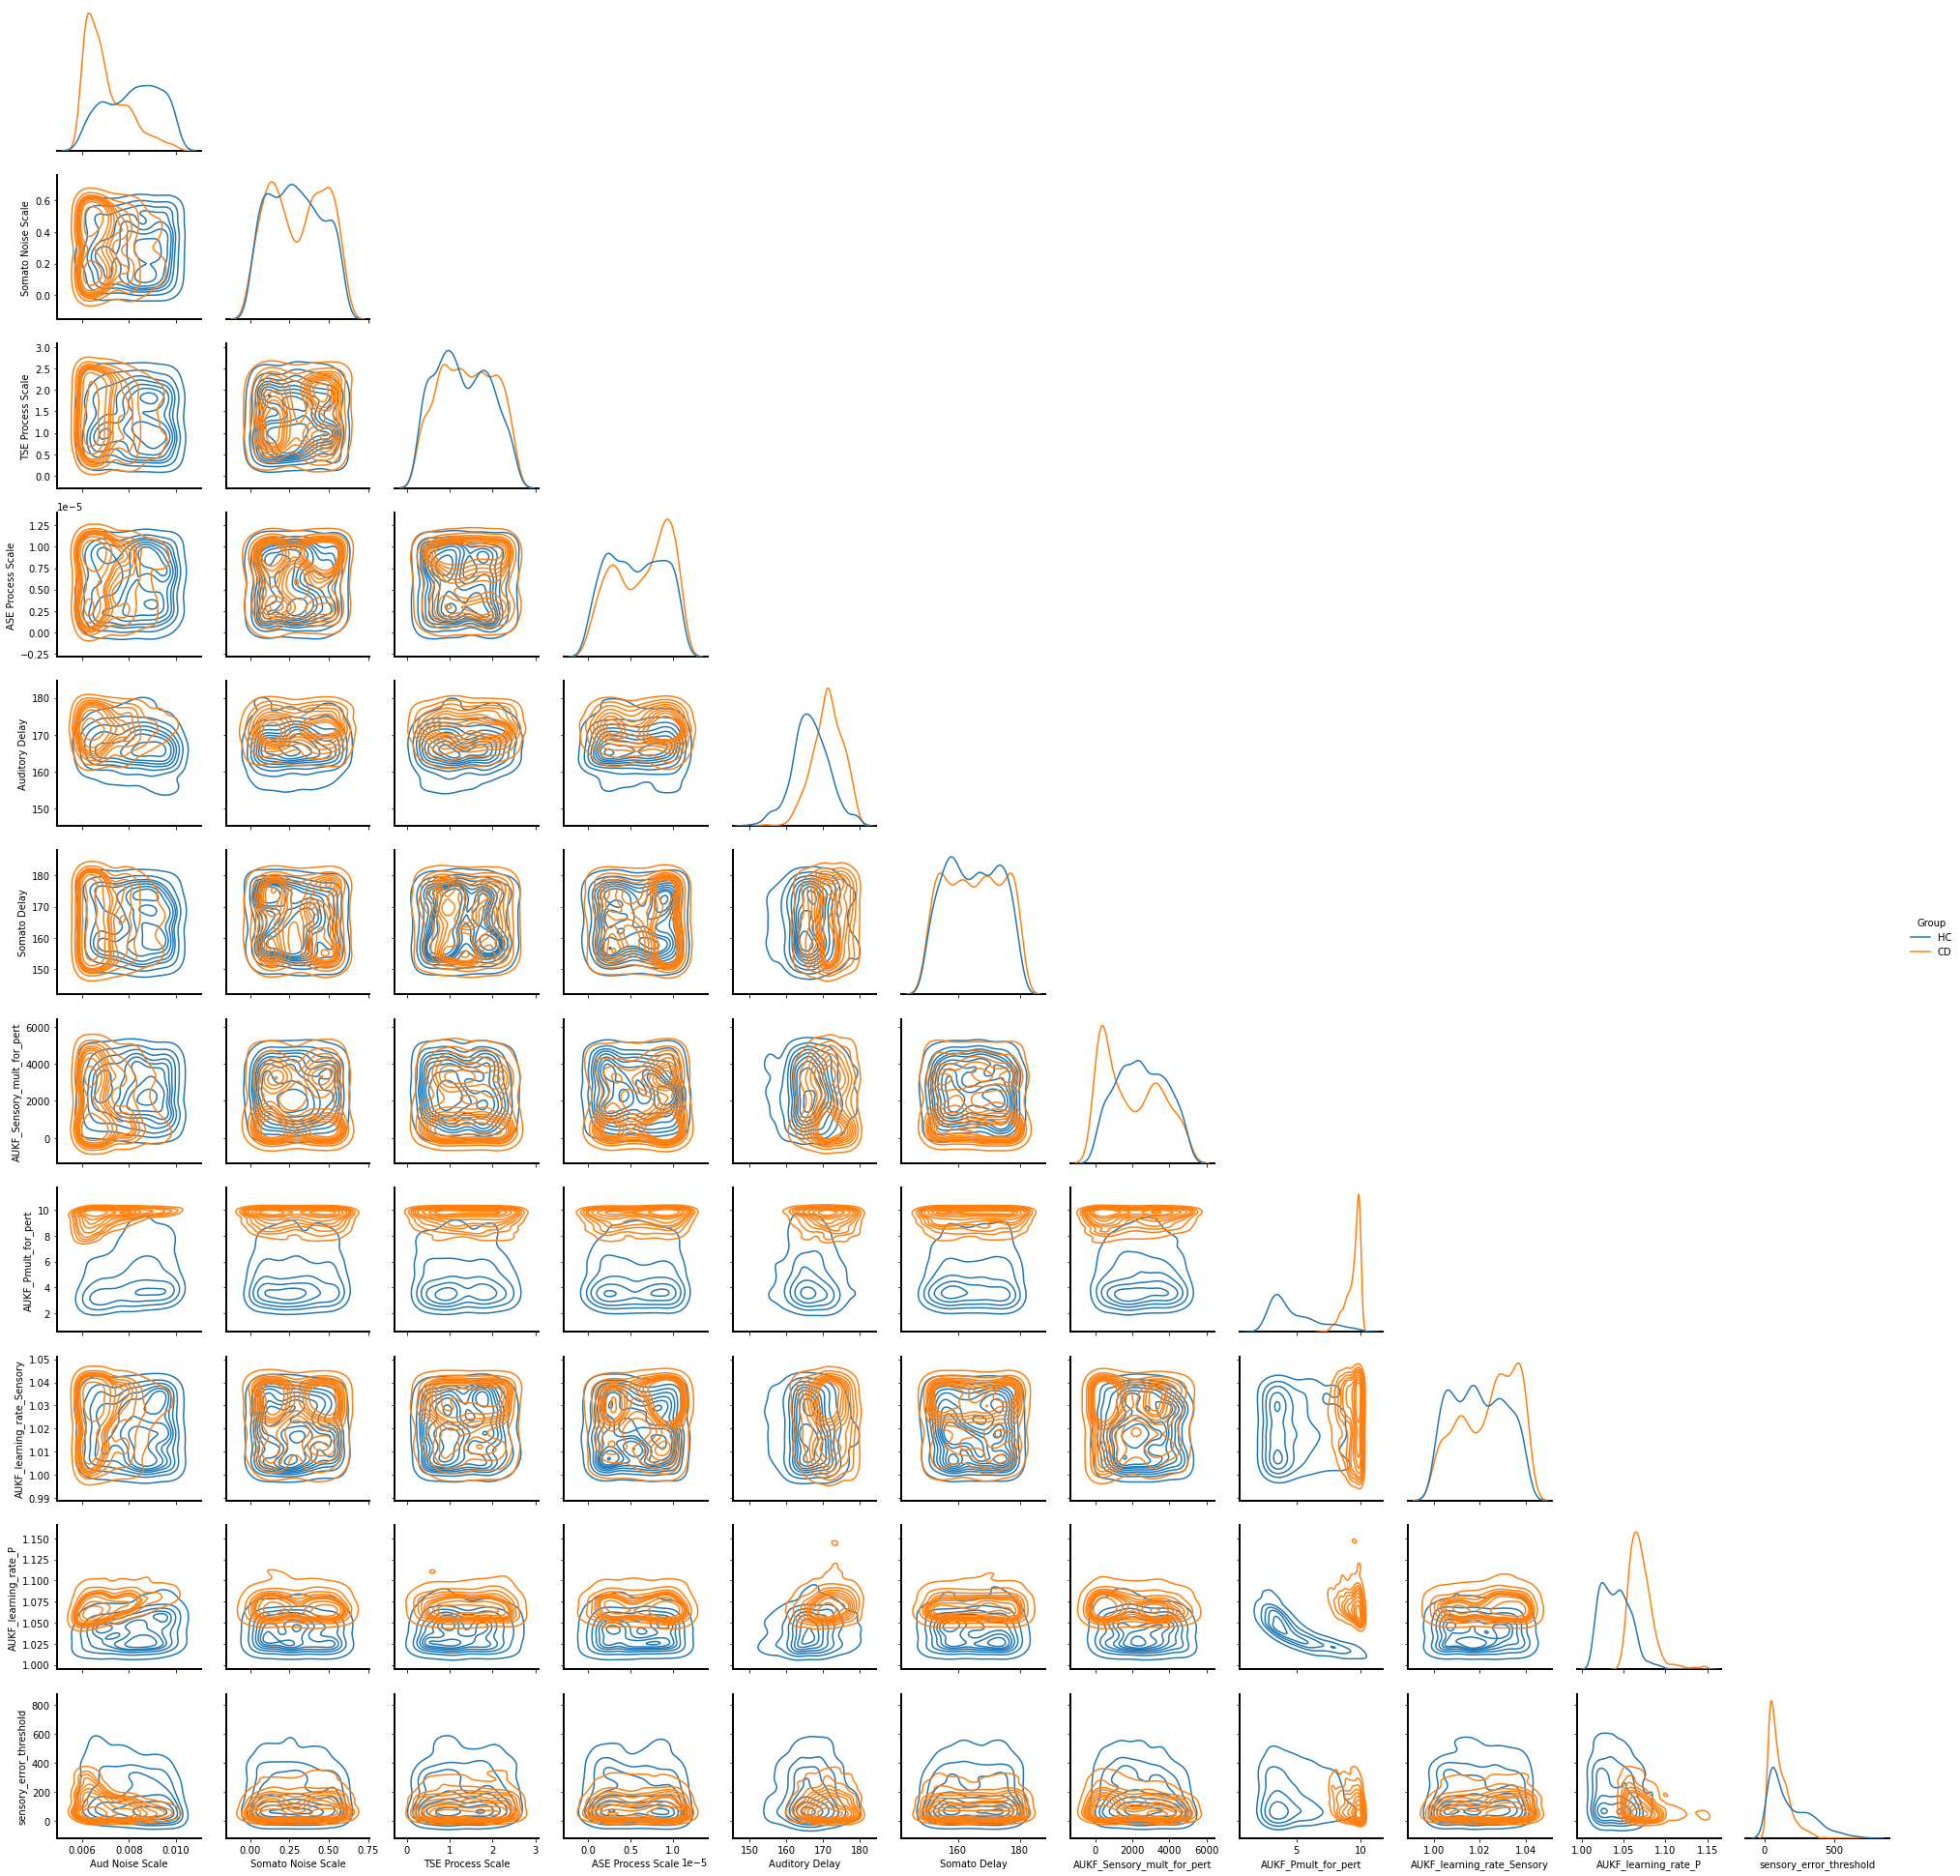

In [51]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_healthy).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

#Append test_FACTS
# px_testFACTS = pd.DataFrame(samples_test_FACTS[1::2]).astype("float")
# px_testFACTS.set_axis(labels, axis="columns", inplace=True)
# px_testFACTS["Group"] = "TestFACTS"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

# g = sns.pairplot(px, corner=True, kind='hist')
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

### Plot estimated formant to observed formant

In [ ]:
# from scipy import stats

# plt.rcParams.update({'font.size': 22})

# torch.set_printoptions(sci_mode=True)

# posterior_modes_FACTS = stats.mode(samples_test_FACTS,0)
# posterior_modes_FACTS = torch.from_numpy(posterior_modes_FACTS[0][0])
# print(f'poster modes {posterior_modes_FACTS}')
# # print(f'original theta {original_theta}')
# # pdb.set_trace()

# all_simulated_formant_facts = np.array([])
# for ii in range(2):
#     all_simulated_formant_facts = FACTS(posterior_modes_FACTS)
#     if ii == 0:
#         all_simulated_formant = all_simulated_formant_facts
#     else:
#         all_simulated_formant = np.vstack((all_simulated_formant, all_simulated_formant_facts))
        
# #pdb.set_trace()
# # simulated_formant = FACTS(posterior_modes_FACTS)
# mean_formants = np.mean(all_simulated_formant, axis=0)
# ci = np.std(all_simulated_formant, axis=0)

# x_time = np.linspace(-200,700, num=140)

# plt.figure(figsize=(14,10))
# # Plot "Estimations"
# plt.plot(x_time, mean_formants, label='estimated from posteriors')
# plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='b', alpha=.1)

# # Plot Empirical Data
# plt.plot(x_time, simulated_test, 'k',label='FACTS output')
# # plt.fill_between(x_time, (simulated_test-healthy_ci), (simulated_test+healthy_ci), color='k', alpha=.1)

# #  plt.axvline(x = 0, color = 'grey', ls=':')
# plt.legend()

# plt.xlabel('Time (ms)')
# plt.ylabel('Formant response (Hz)')
# plt.title('FACTS Empirical')

['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale', 'ASE Process Scale', 'Auditory Delay', 'Somato Delay', 'AUKF_Sensory_mult_for_pert', 'AUKF_Pmult_for_pert', 'AUKF_learning_rate_Sensory', 'AUKF_learning_rate_P', 'sensory_error_threshold']
poster modes tensor([8.281581103801727294921875000000e-03,
        2.815569937229156494140625000000e-01,
        1.231015920639038085937500000000e+00,
        5.470621545100584626197814941406e-06,
        1.664086303710937500000000000000e+02,
        1.650929260253906250000000000000e+02,
        2.445646728515625000000000000000e+03,
        4.179346084594726562500000000000e+00,
        1.018848419189453125000000000000e+00,
        1.040273666381835937500000000000e+00,
        1.349235229492187500000000000000e+02])
compensation_adaptive_frame_on 73 41


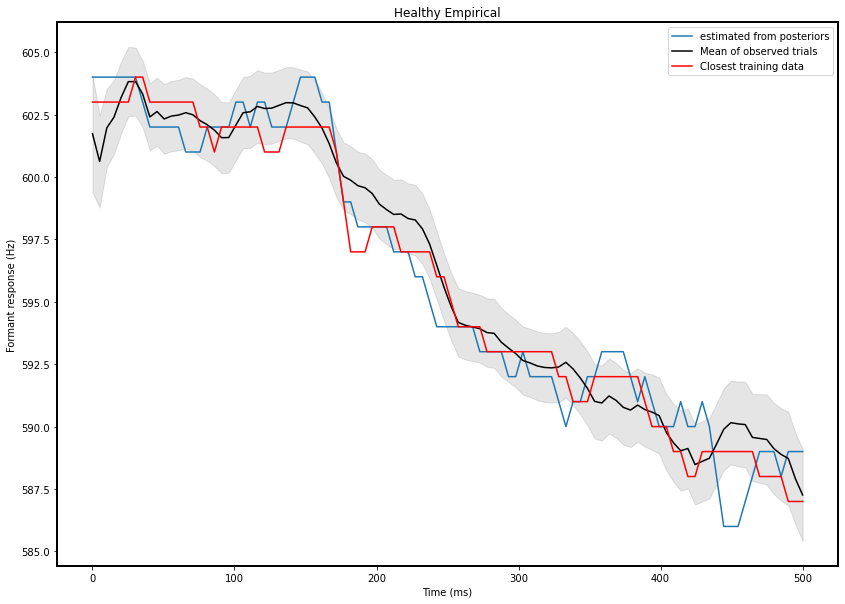

In [52]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=30)

print(labels)
# posterior_modes_HC = stats.mode(samples_healthy,0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

# posterior_modes_HC = get_modes(samples_healthy)
# posterior_modes_HC = np.average(samples_healthy, axis=0)
posterior_modes_HC = np.median(samples_healthy, axis=0)
posterior_modes_HC = torch.from_numpy(posterior_modes_HC)
print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()


# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-2] = 0.98
# posterior_modes_HC_manual_test[2] = 0.04
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

# posterior_modes_HC_manual_test = torch.tensor([0.0005,
#             0.0005,
#             0.1,
#             0.000001, 
#             0.000001, 
#             0.000001,
#             150.0,
#             100.0,
#             100.0,
#             75.0,
#             0.958,
#             6.0]) 

# posterior_modes_HC2 = posterior_modes_HC.clone()
# posterior_modes_HC2[2] = posterior_modes_HC_manual_test[2]


for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)
#     print(f'posterior_modes_HC_manual_test {posterior_modes_HC_manual_test}')
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace() 
    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')

#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
    #     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')


In [53]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)
np.set_printoptions(suppress=True)

best_HC_theta = all_theta[indicesHC[0],:]
print(best_HC_theta)
this_df_HC = pd.DataFrame({'Parameter label': labels,
#                         'posterior_modes_CD_manual_test': posterior_modes_HC_manual_test.numpy().tolist(),
                        'best_training_data':best_HC_theta.numpy().tolist(),
                       'posterior_modes_C': posterior_modes_HC.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_HC - best_HC_theta).numpy().tolist(),
                       'Percent diff': ((posterior_modes_HC - best_HC_theta)/best_HC_theta*100).numpy().tolist()
                       })

display(this_df_HC)


tensor([6.387543864548206329345703125000e-03,
        4.339538812637329101562500000000e-01,
        2.184712409973144531250000000000e+00,
        4.727767191070597618818283081055e-06,
        1.705569305419921875000000000000e+02,
        1.585980834960937500000000000000e+02,
        3.568485839843750000000000000000e+03,
        3.163901567459106445312500000000e+00,
        1.000178813934326171875000000000e+00,
        1.045262932777404785156250000000e+00,
        2.120750885009765625000000000000e+02])


Parameter label  best_training_data  posterior_modes_C  \
0              Aud Noise Scale           0.0063875          0.0082816   
1           Somato Noise Scale           0.4339539          0.2815570   
2            TSE Process Scale           2.1847124          1.2310159   
3            ASE Process Scale           0.0000047          0.0000055   
4               Auditory Delay         170.5569305        166.4086304   
5                 Somato Delay         158.5980835        165.0929260   
6   AUKF_Sensory_mult_for_pert        3568.4858398       2445.6467285   
7          AUKF_Pmult_for_pert           3.1639016          4.1793461   
8   AUKF_learning_rate_Sensory           1.0001788          1.0188484   
9         AUKF_learning_rate_P           1.0452629          1.0402737   
10     sensory_error_threshold         212.0750885        134.9235229   

    difference in parameter tensors  Percent diff  
0                         0.0018940    29.6520443  
1                        -0.1523969   -35.1182213  
2                        -0.9536965   -43.6531830  
3                         0.0000007    15.7125835  
4                        -4.1483002    -2.4322085  
5                         6.4948425     4.0951586  
6                     -1122.8391113   -31.4654198  
7                         1.0154445    32.0946922  
8                         0.0186696     1.8666267  
9                        -0.0049893    -0.4773217  
10                      -77.1515656   -36.3793640

['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale', 'ASE Process Scale', 'Auditory Delay', 'Somato Delay', 'AUKF_Sensory_mult_for_pert', 'AUKF_Pmult_for_pert', 'AUKF_learning_rate_Sensory', 'AUKF_learning_rate_P', 'sensory_error_threshold']
poster modes tensor([6.298419228895708356363858371196e-03,
        1.378534468192909034911508570076e-01,
        8.727787427000097686402568797348e-01,
        9.327984755813289863952096625521e-06,
        1.713294734553889782091573579237e+02,
        1.770485617147909636059921467677e+02,
        3.835831749718468017817940562963e+02,
        9.849619499794593835417799709830e+00,
        1.036710465157234972721767007897e+00,
        1.064739839212075933616574729967e+00,
        4.992880383626118856454922934063e+01], dtype=torch.float64)
compensation_adaptive_frame_on 66 33
compensation_adaptive_frame_off 67 34
compensation_adaptive_frame_on 74 41
% difference in parameter tensors tensor([[  2.370281757315797044327609910397, -61.952649287359

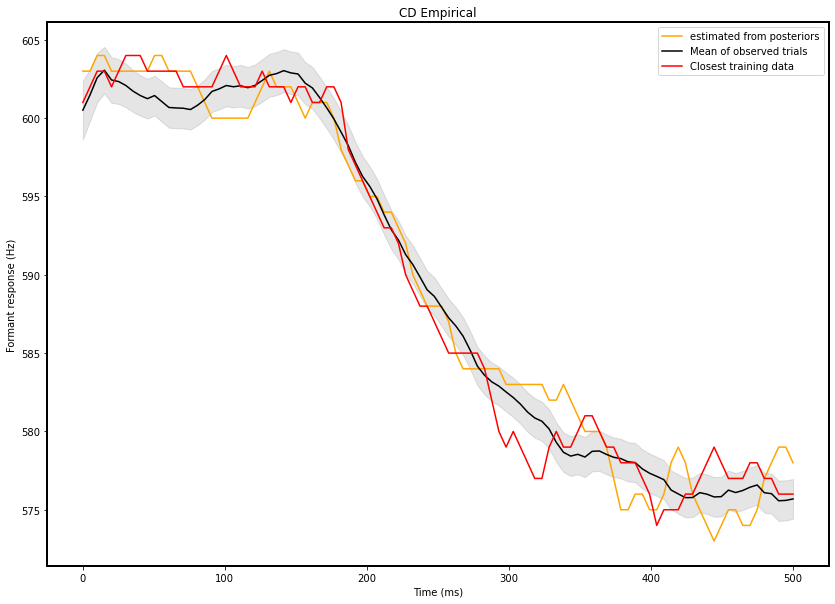

In [54]:
print(labels)
# posterior_modes_C = stats.mode(samples_cereb,0)
# posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])

posterior_modes_C = get_modes(samples_cereb)
# posterior_modes_C = np.median(samples_cereb, axis=0)
# posterior_modes_C = np.average(samples_cereb, axis=0)
posterior_modes_C = torch.from_numpy(posterior_modes_C)

print(f'poster modes {posterior_modes_C}')
# print(posterior_modes.shape)
# pdb.set_trace()

# posterior_modes_C = find_multivariate_mode(samples_cereb_multi, bandwidth=1)#, kernel='epanechnikov')


#posterior_modes_C_manual_test = posterior_modes_C.detach().clone()
posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            150.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
posterior_modes_C2 = posterior_modes_C.clone()
posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_C = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
    
    x_time = np.linspace(0,500, num=100)

    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_C[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, all_simulated_formant_facts
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    #plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
#     plt.plot(x_time, simulated_formant_manual_test2[40:140], 'magenta',label='Manual test')
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
#     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
# print(f'% difference in parameter tensors {(posterior_modes_C - posterior_modes_CD_manual_test)/posterior_modes_CD_manual_test}')
print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta*100}')



In [55]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)

# posterior_modes_C - best_theta)/best_theta
print(best_theta[0].tolist())
print((posterior_modes_C - best_theta[0]).numpy().tolist())
this_df = pd.DataFrame({'Parameter label': labels,
                        'best training data': best_theta[0].tolist(),
                       'posterior_modes_C': posterior_modes_C.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_C - best_theta[0]).numpy().tolist(),
                       'Percent diff': ((posterior_modes_C - best_theta[0])/best_theta[0]*100).numpy().tolist()
                       })

display(this_df)

[0.006152585614472628, 0.36232075095176697, 2.1661994457244873, 1.3608499784822925e-06, 176.79598999023438, 161.5780029296875, 209.18124389648438, 8.898316383361816, 1.0256823301315308, 1.0858553647994995, 115.75595092773438]
[0.00014583361442308072, -0.22446730413247606, -1.2934207030244775, 7.967134777330997e-06, -5.466516534845397, 15.470558785103464, 174.40193107536243, 0.9513031164327774, 0.011028135025704211, -0.021115525587423578, -65.8271470914732]


Parameter label  best training data  posterior_modes_C  \
0              Aud Noise Scale           0.0061526          0.0062984   
1           Somato Noise Scale           0.3623208          0.1378534   
2            TSE Process Scale           2.1661994          0.8727787   
3            ASE Process Scale           0.0000014          0.0000093   
4               Auditory Delay         176.7959900        171.3294735   
5                 Somato Delay         161.5780029        177.0485617   
6   AUKF_Sensory_mult_for_pert         209.1812439        383.5831750   
7          AUKF_Pmult_for_pert           8.8983164          9.8496195   
8   AUKF_learning_rate_Sensory           1.0256823          1.0367105   
9         AUKF_learning_rate_P           1.0858554          1.0647398   
10     sensory_error_threshold         115.7559509         49.9288038   

    difference in parameter tensors  Percent diff  
0                         0.0001458     2.3702818  
1                        -0.2244673   -61.9526493  
2                        -1.2934207   -59.7092159  
3                         0.0000080   585.4528349  
4                        -5.4665165    -3.0919912  
5                        15.4705588     9.5746689  
6                       174.4019311    83.3735988  
7                         0.9513031    10.6908214  
8                         0.0110281     1.0751999  
9                        -0.0211155    -1.9445984  
10                      -65.8271471   -56.8671818

Text(0.5, 1.0, 'Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

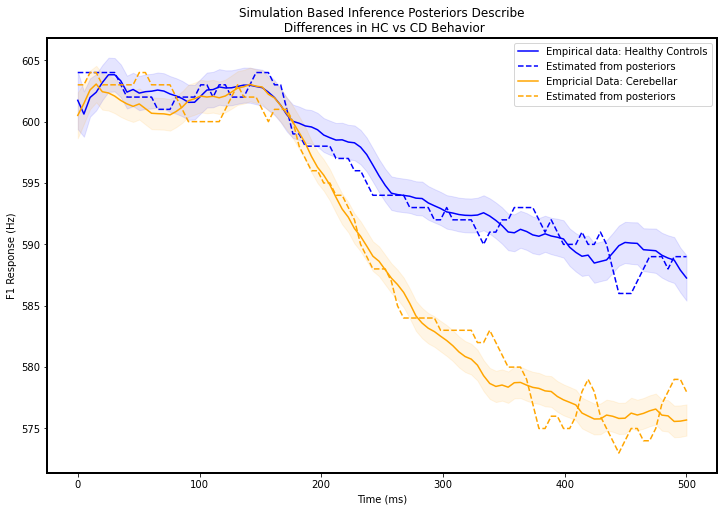

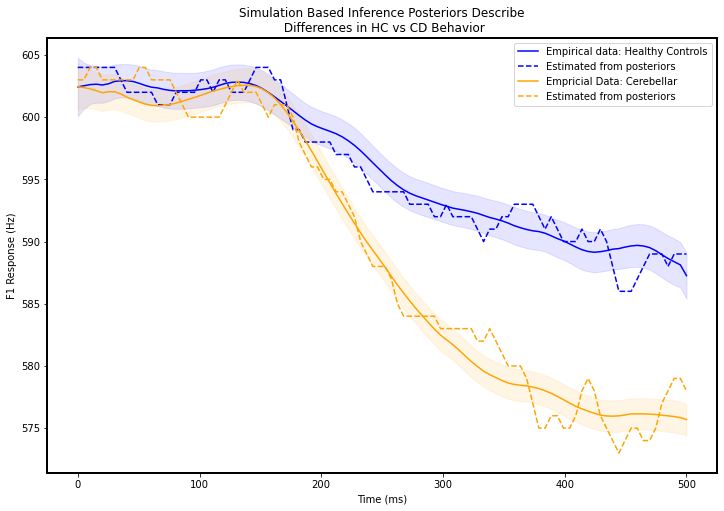

In [56]:
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')



# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

# Ablation Study
Iterate through each of the parameters i.
 
1.  Grab the mode of the CD posteriors
2.  Replace the CD parameter value at index i with an HC parameter value at index i
3.  Store the RMSE of each iteration


In [57]:
from sklearn.metrics import mean_squared_error
# print(posterior_modes_HC)
# print(simulated_formant_H)

# print(posterior_modes_C.shape)
# print(simulated_formant_C)

# posterior_modes_C_np = posterior_modes_C.detach().cpu().numpy()
# posterior_modes_HC_np = posterior_modes_HC.detach().cpu().numpy()

# Store original rmse
original_rmse = np.sqrt(mean_squared_error(simulated_formant_H, simulated_formant_C))

# Initialize lists to store RMSE means and SEMs for ablated parameters
ablated_rmse_means_HC = []
ablated_rmse_means_CD = []

ablated_rmse_sems_HC = []
ablated_rmse_sems_CD = []

# Perform ablation study
num_runs = 3
for i in range(len(posterior_modes_C)):
    print(f'################################################################################### {i} ###################################################################################')
    rmse_values_HC = []
    rmse_values_CD = []
    for _ in range(num_runs):
        # Create an ablated CD tensor
        ablated_CD = posterior_modes_C.clone()
        ablated_CD[i] = posterior_modes_HC[i]
        
        # Run the ablated CD tensor through the simulation function
        ablated_CD_simulation = FACTS(ablated_CD)
        HC_simulation = FACTS(posterior_modes_HC)
        
        # Calculate RMSE for the ablated CD tensor
        rmse_HC = np.sqrt(mean_squared_error(HC_simulation[40:140], healthy_mean_synth[40:140]))
        rmse_CD = np.sqrt(mean_squared_error(ablated_CD_simulation[40:140], cereb_mean_synth[40:140]))
        rmse_values_HC.append(rmse_HC)
        rmse_values_CD.append(rmse_CD)
    
    # Calculate mean and SEM for the RMSE values
    mean_rmse_HC = np.mean(rmse_values_HC)
    mean_rmse_CD = np.mean(rmse_values_CD)
    
    sem_rmse_HC = np.std(rmse_values_HC) / np.sqrt(num_runs)
    sem_rmse_CD = np.std(rmse_values_CD) / np.sqrt(num_runs)
    
    ablated_rmse_means_HC.append(mean_rmse_HC)
    ablated_rmse_means_CD.append(mean_rmse_CD)
    
    ablated_rmse_sems_HC.append(sem_rmse_HC)
    ablated_rmse_sems_CD.append(sem_rmse_CD)
    

# # Plot the RMSE of each ablated parameter with error bars
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(CD)), ablated_rmse_means, yerr=ablated_rmse_sems, capsize=5, tick_label=[f'Param {i+1}' for i in range(len(CD))])
# plt.axhline(y=original_rmse, color='r', linestyle='--', label='Original CD RMSE')
# plt.xlabel('Ablated Parameter Index')
# plt.ylabel('RMSE')
# plt.title('Mean RMSE with SEM for Each Ablated Parameter (CD vs HC)')
# plt.legend()
# plt.show()

################################################################################### 0 ###################################################################################
compensation_adaptive_frame_on 50 17
compensation_adaptive_frame_off 51 18
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 35 2
compensation_adaptive_frame_off 36 3
compensation_adaptive_frame_on 40 7
compensation_adaptive_frame_off 41 8
compensation_adaptive_frame_on 50 17
compensation_adaptive_frame_off 51 18
compensation_adaptive_frame_on 56 23
compensation_adaptive_frame_off 57 24
compensation_adaptive_frame_on 60 27
compensation_adaptive_frame_off 61 28
compensation_adaptive_frame_on 69 36
compensation_adaptive_frame_off 70 37
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 37 4
compensation_adaptive_frame_off 38 5
compensation_adaptive_frame_on 39 6
compensation_adaptive_frame_off 40 7
compensation_ad

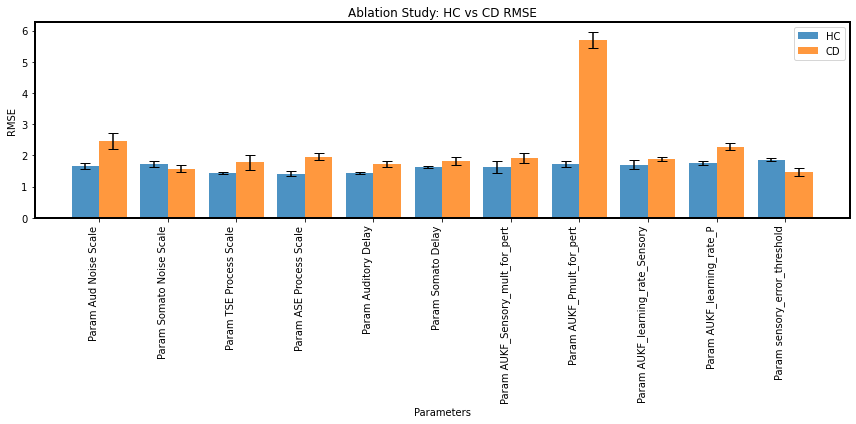

In [58]:
# Example parameter labels (replace with your actual parameter names or indices)
parameter_labels = [f'{label}' for i, label in enumerate(labels)]

# X-axis positions for grouped bars
x = np.arange(len(parameter_labels))

# Bar width for grouped bars
bar_width = 0.4

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, ablated_rmse_means_HC, bar_width, yerr=ablated_rmse_sems_HC, capsize=5, label='HC', alpha=0.8)
plt.bar(x + bar_width / 2, ablated_rmse_means_CD, bar_width, yerr=ablated_rmse_sems_CD, capsize=5, label='CD', alpha=0.8)

# Customize the plot
plt.xticks(x, parameter_labels, rotation=90, ha='right')
# plt.axhline(y=original_rmse, color='r', linestyle='--', label='Original RMSE (CD)')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('Ablation Study: HC vs CD RMSE')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


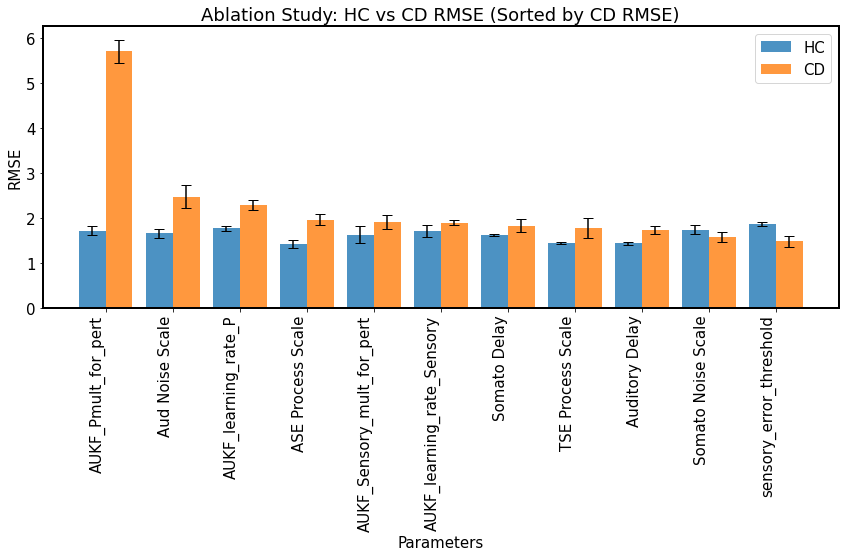

In [67]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})

# Sort data in descending order of CD RMSE
sorted_indices = np.argsort(ablated_rmse_means_CD)[::-1]
ablated_rmse_means_HC_sorted = np.array(ablated_rmse_means_HC)[sorted_indices]
ablated_rmse_means_CD_sorted = np.array(ablated_rmse_means_CD)[sorted_indices]
ablated_rmse_sems_HC_sorted = np.array(ablated_rmse_sems_HC)[sorted_indices]
ablated_rmse_sems_CD_sorted = np.array(ablated_rmse_sems_CD)[sorted_indices]
parameter_labels_sorted = [parameter_labels[i] for i in sorted_indices]

# X-axis positions for grouped bars
x = np.arange(len(parameter_labels_sorted))

# Bar width for grouped bars
bar_width = 0.4

# Create the grouped bar plot
plt.figure(figsize=(12, 8))  # Increased height from 6 to 8
plt.bar(x - bar_width / 2, ablated_rmse_means_HC_sorted, bar_width, yerr=ablated_rmse_sems_HC_sorted, capsize=5, label='HC', alpha=0.8)
plt.bar(x + bar_width / 2, ablated_rmse_means_CD_sorted, bar_width, yerr=ablated_rmse_sems_CD_sorted, capsize=5, label='CD', alpha=0.8)

# Customize the plot
plt.xticks(x, parameter_labels_sorted, rotation=90, ha='right')
# plt.axhline(y=original_rmse, color='r', linestyle='--', label='Original RMSE (CD)')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('Ablation Study: HC vs CD RMSE (Sorted by CD RMSE)')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Marginal Sensitivity Analysis

15 parameters x 5 stds x 3 runs x 8 seconds each run = 1800 seconds or 30 minutes

In [60]:
# Initialize results storage
sensitivity_rmse_means_HC = []
sensitivity_rmse_means_CD = []
sensitivity_rmse_sems_HC = []
sensitivity_rmse_sems_CD = []
simulation_outputs_HC = {}
simulation_outputs_CD = {}

In [61]:
# Define perturbation levels
perturbations = [-3, -1.5, 0, 1.5, 3] #[0, 1, -1, 2, -2]

print(samples_healthy.shape)
std_devs_HC = samples_healthy.std(dim=0, unbiased=True) #np.std(samples_healthy, axis=0)
std_devs_C = samples_cereb.std(dim=0, unbiased=True) #np.std(samples_cereb, axis=0)

# Marginal sensitivity analysis
num_runs = 3
for i, (hc_mode, cd_mode, hc_std, cd_std) in enumerate(zip(posterior_modes_HC, posterior_modes_C, std_devs_HC, std_devs_C)): # 15 params
    print(f'################################################################################### {i} ###################################################################################')
    rmse_values_HC = []
    rmse_values_CD = []
    
    sem_values_HC = []
    sem_values_CD = []
    
    simulation_outputs_HC[i] = []
    simulation_outputs_CD[i] = []

    for p in perturbations: # 5
        perturbed_HC = posterior_modes_HC.clone()
        perturbed_CD = posterior_modes_C.clone()
        
        # Apply perturbations
        perturbed_HC[i] += p * hc_std
        perturbed_CD[i] += p * cd_std

        hc_simulation_runs = []
        cd_simulation_runs = []
        rmse_runs_HC = []
        rmse_runs_CD = []

        for _ in range(num_runs): # 3 runs
            # Run simulations
            hc_sim = FACTS(perturbed_HC)
            cd_sim = FACTS(perturbed_CD)

            # Store simulations for later plotting
            hc_simulation_runs.append(hc_sim)
            cd_simulation_runs.append(cd_sim)

            # Calculate RMSE
#             if p==0:
#                 pdb.set_trace()
            rmse_runs_HC.append(np.sqrt(mean_squared_error(hc_sim[40:140], healthy_mean_synth[40:140])))
            rmse_runs_CD.append(np.sqrt(mean_squared_error(cd_sim[40:140], cereb_mean_synth[40:140])))
        
#             sem_runs_HC.append(np.std(rmse_runs_HC, axis=0) / np.sqrt(num_runs))
#             sem_runs_CD.append(np.std(rmse_runs_CD, axis=0) / np.sqrt(num_runs))

        # Store mean simulations
#         pdb.set_trace()
        simulation_outputs_HC[i].append(torch.stack(hc_simulation_runs).mean(dim=0))
        simulation_outputs_CD[i].append(torch.stack(cd_simulation_runs).mean(dim=0))

        # Store RMSE mean and SEM
        rmse_values_HC.append(np.mean(rmse_runs_HC))
        rmse_values_CD.append(np.mean(rmse_runs_CD))
        
        sem_values_HC.append(np.std(rmse_runs_HC, axis=0) / np.sqrt(num_runs))
        sem_values_CD.append(np.std(rmse_runs_CD, axis=0) / np.sqrt(num_runs))
#         sem_values_HC.append(np.mean(sem_runs_HC))
#         sem_values_CD.append(np.mean(sem_runs_CD))
    
    # Aggregate results
    sensitivity_rmse_means_HC.append(rmse_values_HC)
    sensitivity_rmse_means_CD.append(rmse_values_CD)
    sensitivity_rmse_sems_HC.append(sem_values_HC)
    sensitivity_rmse_sems_CD.append(sem_values_CD)

torch.Size([1000, 11])
################################################################################### 0 ###################################################################################
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 43 10
compensation_adaptive_frame_off 44 11
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 35 2
compensation_adaptive_frame_off 36 3
compensation_adaptive_frame_on 45 12
compensation_adaptive_frame_off 46 13
compensation_adaptive_frame_o

Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception o

Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
compensation_adaptive_frame_on 47 14
Chol exception occurred
Chol exception occurred
compensation_adaptive_frame_off 48 15
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
compensation_adaptive_frame_on 56 23
Chol exception occurred
compensation_adaptive_frame_off 57 24
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol excep

compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 68 36
compensation_adaptive_frame_off 69 37
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 38 5
compensation_adaptive_frame_off 39 6
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 42 9
compensation_adaptive_frame_off 43 10
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 55 22
compensation_adaptive_frame_off 56 23
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 36 3
compensation_adaptive_frame_off 37 4
compensation_adaptive_frame_on 70 37
compensation_adaptive_frame_off 71 38
compensation_adaptive_frame_on 74 41


compensation_adaptive_frame_on 71 38
compensation_adaptive_frame_off 72 39
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 47 14
compensation_adaptive_frame_off 48 15
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 60 27
compensation_adaptive_frame_off 61 28
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 37
compensation_adaptive_frame_off 71 38
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 70 

Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
Chol exception occurred
compensation_adaptive_frame_on 46 13
compensation_adaptive_frame_off 47 14
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 64 32
compensation_adaptive_frame_off 65 

In [62]:
print(sensitivity_rmse_means_HC[0])
print(sensitivity_rmse_sems_CD[0])

[3.3874815316567197, 1.7383156678491127, 1.5520209981070072, 1.659879006289714, 2.1940250313808503]
[0.22062481493212555, 0.3421378757582644, 0.07952069880490258, 0.021408641530091473, 0.3603411719049609]


/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


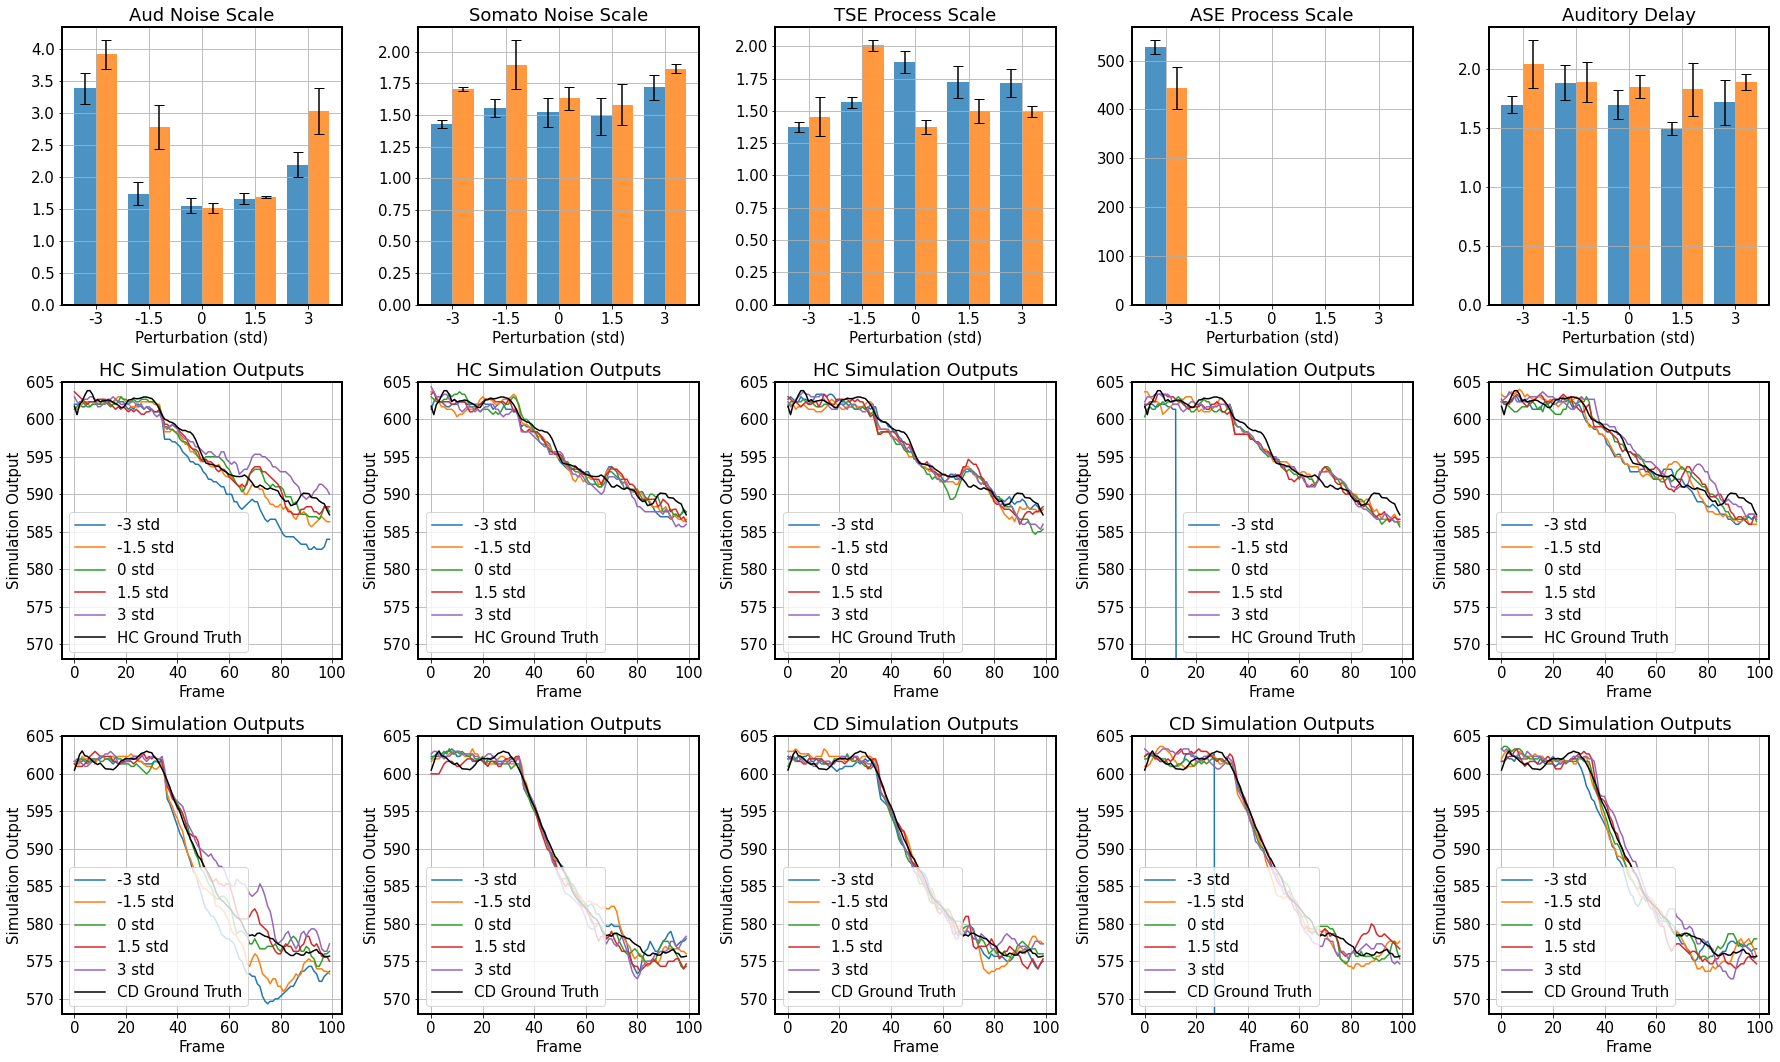

In [68]:
num_of_params = 5
# Example parameter labels (replace with actual labels)
parameter_labels = [f'{label}' for i, label in enumerate(labels)]

# Perturbation levels for x-axis
# perturbations = [-2,-1,0,1,2] #[0, 1, -1, 2, -2]

# sorted_indices = np.argsort(perturbations)
# sorted_perturbations = [perturbations[i] for i in sorted_indices]

# Create subplots with 3 rows and len(parameter_labels) columns
# num_params = len(parameter_labels)
fig, axes = plt.subplots(3, num_of_params, figsize=(25, 15), constrained_layout=True, sharey=False)

for i, param_label in enumerate(parameter_labels[:num_of_params]):
    # Row 1: RMSE vs Perturbation for HC and CD
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_HC[i], 
#                         yerr=sensitivity_rmse_sems_HC[i], label='HC', fmt='-o')
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_CD[i], 
#                         yerr=sensitivity_rmse_sems_CD[i], label='CD', fmt='-o')
#     axes[0, i].set_title(f'{param_label}')
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#     sorted_rmse_means_HC = [sensitivity_rmse_means_HC[i][j] for j in sorted_indices]
#     sorted_rmse_means_CD = [sensitivity_rmse_means_CD[i][j] for j in sorted_indices]
#     sorted_sems_HC = [sensitivity_rmse_sems_HC[j] for j in sorted_indices]
#     sorted_sems_CD = [sensitivity_rmse_sems_CD[j] for j in sorted_indices]
    
#     x = np.arange(len(sorted_perturbations))
#     bar_width = 0.35
#     axes[0, i].bar(x - bar_width / 2, sorted_rmse_means_HC, bar_width,
# #                    yerr=sorted_sems_HC, 
#                    capsize=5, label='HC', alpha=0.8)
#     axes[0, i].bar(x + bar_width / 2, sorted_rmse_means_CD, bar_width,
# #                    yerr=sorted_sems_CD, 
#                    capsize=5, label='CD', alpha=0.8)
#     axes[0, i].set_title(param_label)
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].set_xticks(x)
#     axes[0, i].set_xticklabels(sorted_perturbations)
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#      # Plot HC and CD bars side by side
    x = np.arange(len(perturbations))
    axes[0, i].bar(x - bar_width / 2, sensitivity_rmse_means_HC[i], bar_width,
                yerr=sensitivity_rmse_sems_HC[i], capsize=5, label='HC', alpha=0.8)
    axes[0, i].bar(x + bar_width / 2, sensitivity_rmse_means_CD[i], bar_width,
                yerr=sensitivity_rmse_sems_CD[i], capsize=5, label='CD', alpha=0.8)

    # Customize the plot
    axes[0, i].set_title(param_label)
    axes[0, i].set_xlabel('Perturbation (std)')
    axes[0, i].set_xticks(x)
    axes[0, i].set_xticklabels(perturbations)
    axes[0, i].grid(True)

    # Row 2: Simulation Outputs for HC Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[1, i].plot(simulation_outputs_HC[i][j][40:140], label=f'{perturbation} std')
    axes[1, i].plot(healthy_mean_synth[40:140], label=f'HC Ground Truth', color='k')
    axes[1, i].set_xlabel('Frame')
    axes[1, i].set_ylabel('Simulation Output')
    axes[1, i].set_title(f'HC Simulation Outputs')
    axes[1, i].legend()
    axes[1, i].grid(True)
    axes[1, i].set_ylim([568,605])

    # Row 3: Simulation Outputs for CD Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[2, i].plot(simulation_outputs_CD[i][j][40:140], label=f'{perturbation} std')
    axes[2, i].plot(cereb_mean_synth[40:140], label=f'CD Ground Truth', color='k')
    axes[2, i].set_xlabel('Frame')
    axes[2, i].set_ylabel('Simulation Output')
    axes[2, i].set_title(f'CD Simulation Outputs')
    axes[2, i].legend()
    axes[2, i].grid(True)
    axes[2, i].set_ylim([568,605])

# Set overall plot title and adjust layout
# plt.suptitle('Sensitivity Analysis: RMSE and Simulation Outputs', fontsize=16)
plt.tight_layout()
plt.show()

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


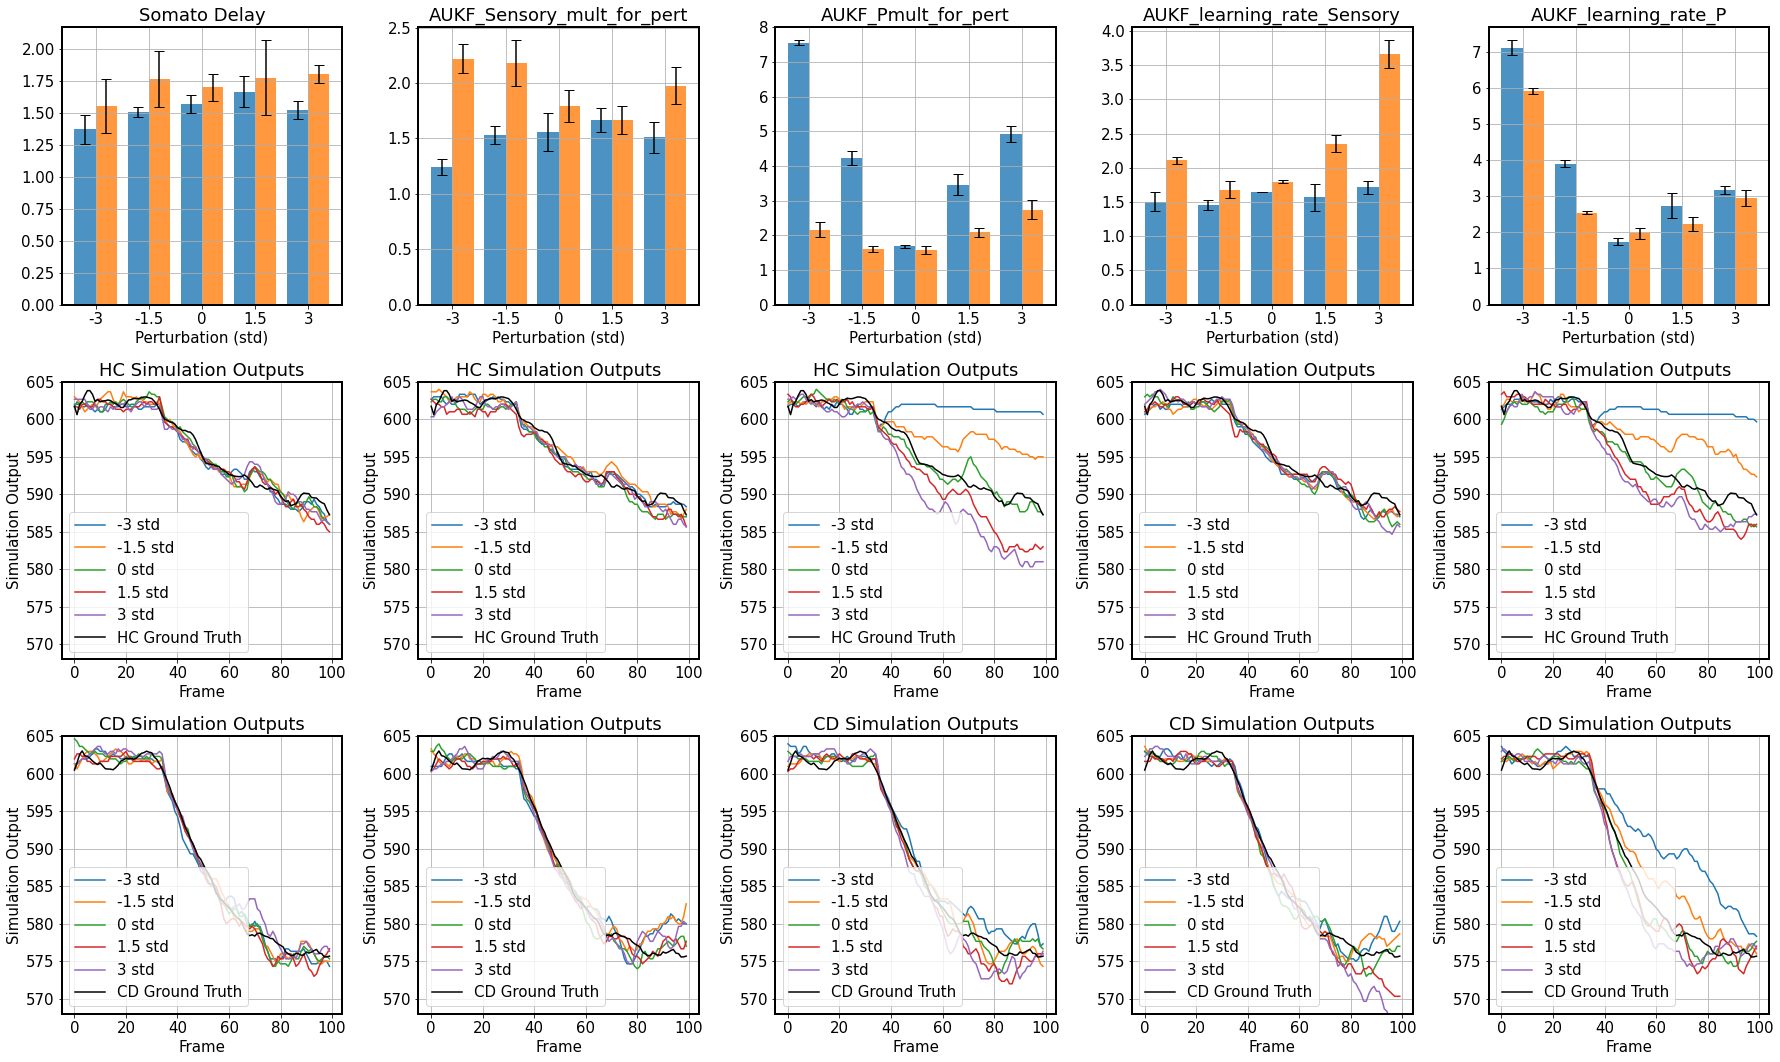

In [69]:
# num_params = len(parameter_labels)
offset = 5
fig, axes = plt.subplots(3, num_of_params, figsize=(25, 15), constrained_layout=True, sharey=False)

for i, param_label in enumerate(parameter_labels[offset:offset+num_of_params]):
    ii=i+offset
    # Row 1: RMSE vs Perturbation for HC and CD
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_HC[i], 
#                         yerr=sensitivity_rmse_sems_HC[i], label='HC', fmt='-o')
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_CD[i], 
#                         yerr=sensitivity_rmse_sems_CD[i], label='CD', fmt='-o')
#     axes[0, i].set_title(f'{param_label}')
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#     sorted_rmse_means_HC = [sensitivity_rmse_means_HC[i][j] for j in sorted_indices]
#     sorted_rmse_means_CD = [sensitivity_rmse_means_CD[i][j] for j in sorted_indices]
#     sorted_sems_HC = [sensitivity_rmse_sems_HC[j] for j in sorted_indices]
#     sorted_sems_CD = [sensitivity_rmse_sems_CD[j] for j in sorted_indices]
    
#     x = np.arange(len(sorted_perturbations))
#     bar_width = 0.35
#     axes[0, i].bar(x - bar_width / 2, sorted_rmse_means_HC, bar_width,
# #                    yerr=sorted_sems_HC, 
#                    capsize=5, label='HC', alpha=0.8)
#     axes[0, i].bar(x + bar_width / 2, sorted_rmse_means_CD, bar_width,
# #                    yerr=sorted_sems_CD, 
#                    capsize=5, label='CD', alpha=0.8)
#     axes[0, i].set_title(param_label)
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].set_xticks(x)
#     axes[0, i].set_xticklabels(sorted_perturbations)
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#      # Plot HC and CD bars side by side
    x = np.arange(len(perturbations))
    axes[0, i].bar(x - bar_width / 2, sensitivity_rmse_means_HC[ii], bar_width,
                yerr=sensitivity_rmse_sems_HC[ii], capsize=5, label='HC', alpha=0.8)
    axes[0, i].bar(x + bar_width / 2, sensitivity_rmse_means_CD[ii], bar_width,
                yerr=sensitivity_rmse_sems_CD[ii], capsize=5, label='CD', alpha=0.8)

    # Customize the plot
    axes[0, i].set_title(param_label)
    axes[0, i].set_xlabel('Perturbation (std)')
    axes[0, i].set_xticks(x)
    axes[0, i].set_xticklabels(perturbations)
    axes[0, i].grid(True)

    # Row 2: Simulation Outputs for HC Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[1, i].plot(simulation_outputs_HC[ii][j][40:140], label=f'{perturbation} std')
    axes[1, i].plot(healthy_mean_synth[40:140], '-', label=f'HC Ground Truth', color='k')
    axes[1, i].set_xlabel('Frame')
    axes[1, i].set_ylabel('Simulation Output')
    axes[1, i].set_title(f'HC Simulation Outputs')
    axes[1, i].legend()
    axes[1, i].grid(True)
    axes[1, i].set_ylim([568,605])

    # Row 3: Simulation Outputs for CD Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[2, i].plot(simulation_outputs_CD[ii][j][40:140], label=f'{perturbation} std')
    axes[2, i].plot(cereb_mean_synth[40:140], label=f'CD Ground Truth', color='k')
    axes[2, i].set_xlabel('Frame')
    axes[2, i].set_ylabel('Simulation Output')
    axes[2, i].set_title(f'CD Simulation Outputs')
    axes[2, i].legend()
    axes[2, i].grid(True)
    axes[2, i].set_ylim([568,605])

# Set overall plot title and adjust layout
# plt.suptitle('Sensitivity Analysis: RMSE and Simulation Outputs', fontsize=16)
plt.tight_layout()
plt.show()

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


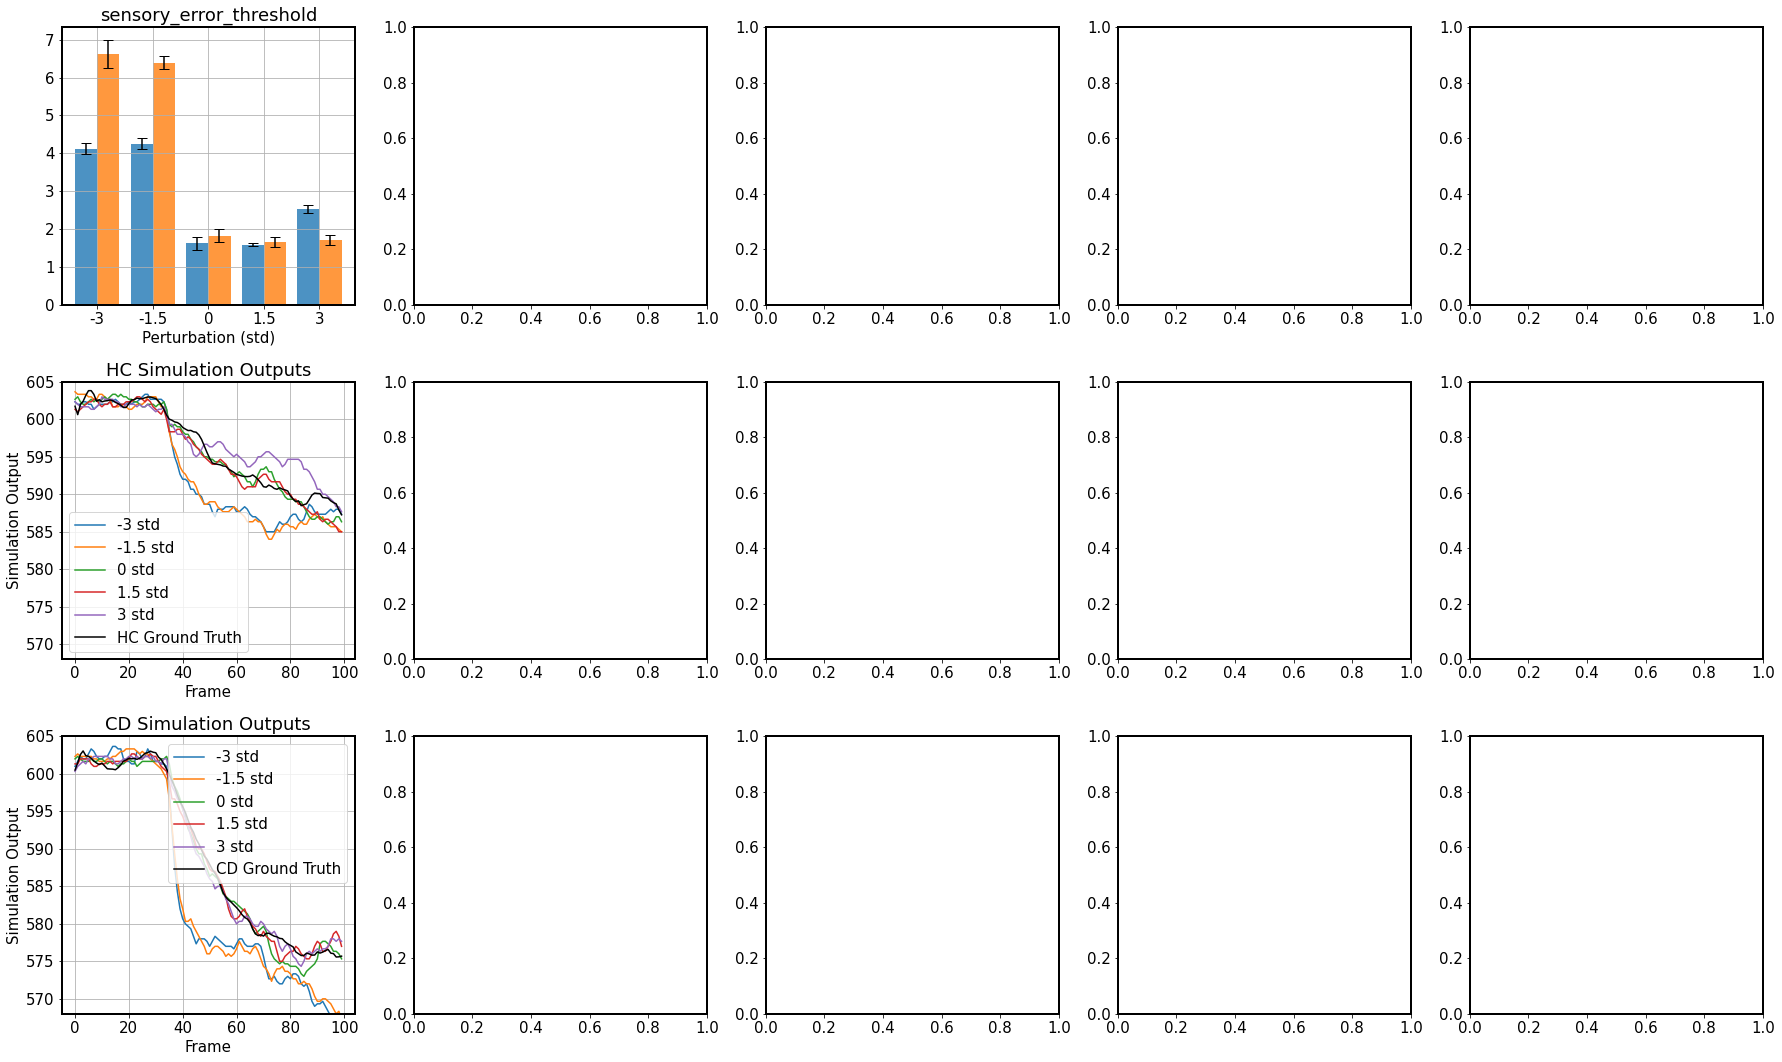

In [70]:
# num_params = len(parameter_labels)
offset = 10
fig, axes = plt.subplots(3, num_of_params, figsize=(25, 15), constrained_layout=True, sharey=False)

for i, param_label in enumerate(parameter_labels[offset:offset+num_of_params]):
    ii=i+offset
    # Row 1: RMSE vs Perturbation for HC and CD
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_HC[i], 
#                         yerr=sensitivity_rmse_sems_HC[i], label='HC', fmt='-o')
#     axes[0, i].errorbar(perturbations, sensitivity_rmse_means_CD[i], 
#                         yerr=sensitivity_rmse_sems_CD[i], label='CD', fmt='-o')
#     axes[0, i].set_title(f'{param_label}')
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#     sorted_rmse_means_HC = [sensitivity_rmse_means_HC[i][j] for j in sorted_indices]
#     sorted_rmse_means_CD = [sensitivity_rmse_means_CD[i][j] for j in sorted_indices]
#     sorted_sems_HC = [sensitivity_rmse_sems_HC[j] for j in sorted_indices]
#     sorted_sems_CD = [sensitivity_rmse_sems_CD[j] for j in sorted_indices]
    
#     x = np.arange(len(sorted_perturbations))
#     bar_width = 0.35
#     axes[0, i].bar(x - bar_width / 2, sorted_rmse_means_HC, bar_width,
# #                    yerr=sorted_sems_HC, 
#                    capsize=5, label='HC', alpha=0.8)
#     axes[0, i].bar(x + bar_width / 2, sorted_rmse_means_CD, bar_width,
# #                    yerr=sorted_sems_CD, 
#                    capsize=5, label='CD', alpha=0.8)
#     axes[0, i].set_title(param_label)
#     axes[0, i].set_xlabel('Perturbation (std)')
#     axes[0, i].set_ylabel('RMSE')
#     axes[0, i].set_xticks(x)
#     axes[0, i].set_xticklabels(sorted_perturbations)
#     axes[0, i].legend()
#     axes[0, i].grid(True)

#      # Plot HC and CD bars side by side
    x = np.arange(len(perturbations))
    axes[0, i].bar(x - bar_width / 2, sensitivity_rmse_means_HC[ii], bar_width,
                yerr=sensitivity_rmse_sems_HC[ii], capsize=5, label='HC', alpha=0.8)
    axes[0, i].bar(x + bar_width / 2, sensitivity_rmse_means_CD[ii], bar_width,
                yerr=sensitivity_rmse_sems_CD[ii], capsize=5, label='CD', alpha=0.8)

    # Customize the plot
    axes[0, i].set_title(param_label)
    axes[0, i].set_xlabel('Perturbation (std)')
    axes[0, i].set_xticks(x)
    axes[0, i].set_xticklabels(perturbations)
    axes[0, i].grid(True)

    # Row 2: Simulation Outputs for HC Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[1, i].plot(simulation_outputs_HC[ii][j][40:140], label=f'{perturbation} std')
    axes[1, i].plot(healthy_mean_synth[40:140], '-', label=f'HC Ground Truth', color='k')
    axes[1, i].set_xlabel('Frame')
    axes[1, i].set_ylabel('Simulation Output')
    axes[1, i].set_title(f'HC Simulation Outputs')
    axes[1, i].legend()
    axes[1, i].grid(True)
    axes[1, i].set_ylim([568,605])

    # Row 3: Simulation Outputs for CD Perturbations
    for j, perturbation in enumerate(perturbations):
        axes[2, i].plot(simulation_outputs_CD[ii][j][40:140], label=f'{perturbation} std')
    axes[2, i].plot(cereb_mean_synth[40:140], label=f'CD Ground Truth', color='k')
    axes[2, i].set_xlabel('Frame')
    axes[2, i].set_ylabel('Simulation Output')
    axes[2, i].set_title(f'CD Simulation Outputs')
    axes[2, i].legend()
    axes[2, i].grid(True)
    axes[2, i].set_ylim([568,605])

# Set overall plot title and adjust layout
# plt.suptitle('Sensitivity Analysis: RMSE and Simulation Outputs', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
print(sensitivity_rmse_sems_HC[0])
print(sensitivity_rmse_means_CD[0])
sensitivity_rmse_sems_HC

## Plot CD and HC in same plot

In [ ]:
# Plot Healthy Estimated
# plt.plot(x_time, mean_formants_HC, linestyle='--', label='Estimated from posteriors')
# ci_HC = (1.96 * np.std(all_simulated_formant_HC,axis=0)/np.sqrt(all_simulated_formant_HC.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_HC-ci_HC), (mean_formants_HC+ci_HC), color='b', alpha=.1)
# # Plot Healthy observed
# plt.plot(x_time, healthy_mean_synth[40:140], color='b',label='Mean of observed trials')
# plt.fill_between(x_time, (healthy_mean_synth[40:140]-cereb_ci_ds), (healthy_mean_synth[40:140]+cereb_ci_ds), color='b', alpha=.1)



# # Plot CD Estimated
# plt.plot(x_time, mean_formants_CD, 'orange', linestyle='--',label='Estimated from posteriors')
# ci_CD = (1.96 * np.std(all_simulated_formant_CD,axis=0)/np.sqrt(all_simulated_formant_CD.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_CD-ci_CD), (mean_formants_CD+ci_CD), color='orange', alpha=.1)
# # Plot CD observed
# plt.plot(x_time, cereb_mean_synth[40:140], 'orange', linestyle='-', label='Mean of observed trials')
# plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)



### Plot without truncating, just to see

In [ ]:
# posterior_modes_C = stats.mode(samples_cereb,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])
print(f'poster modes {posterior_modes_C}')
print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()

# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-1] = 8
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

all_simulated_formant = np.array([])
for ii in range(2):
    simulated_formant = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace()
    if ii == 0:
        all_simulated_formant = simulated_formant
    else:
        all_simulated_formant = np.vstack((all_simulated_formant, simulated_formant))
    
    
# # Plot data
x_time = np.linspace(-200,500, num=140)

mean_formants = np.mean(all_simulated_formant, axis=0)
plt.figure(figsize=(14,10))
plt.plot(x_time, mean_formants, 'orange' ,label='Estimated from posteriors')
ci = (1.96 * np.std(all_simulated_formant,axis=0)/np.sqrt(all_simulated_formant.shape[0]))
plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='orange', alpha=.1)

plt.plot(x_time, cereb_mean_synth, 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual test')
#     plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('CD Empirical')

Interpret Glass effect size
https://www.uv.es/~friasnav/EffectSizeBecker.pdf

Group                 variable       value
0        CD          Aud Noise Scale   0.0082109
1        CD          Aud Noise Scale   0.0073959
2        CD          Aud Noise Scale   0.0060464
3        CD          Aud Noise Scale   0.0062004
4        CD          Aud Noise Scale   0.0062846
...     ...                      ...         ...
21995    HC  sensory_error_threshold 518.6557007
21996    HC  sensory_error_threshold 427.9133911
21997    HC  sensory_error_threshold  30.9715710
21998    HC  sensory_error_threshold 365.3341370
21999    HC  sensory_error_threshold 191.3518677

[22000 rows x 3 columns]

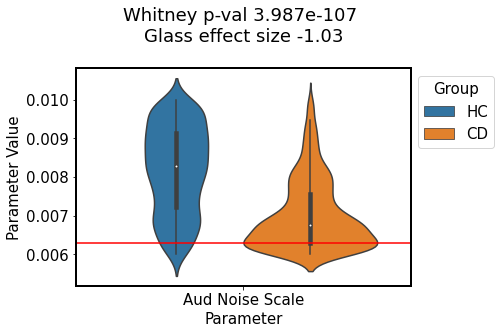

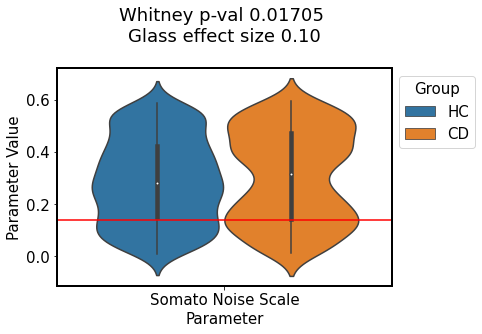

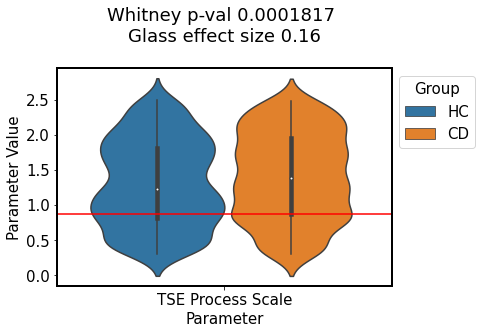

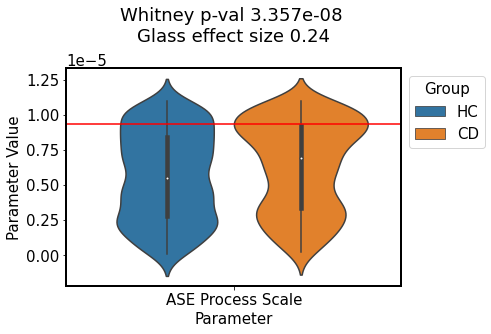

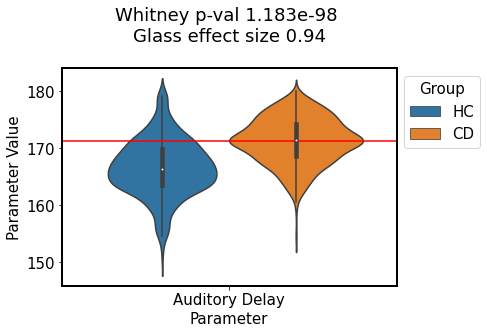

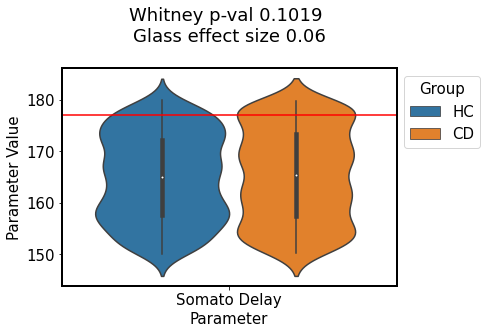

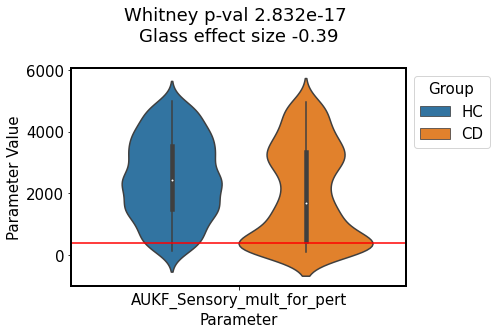

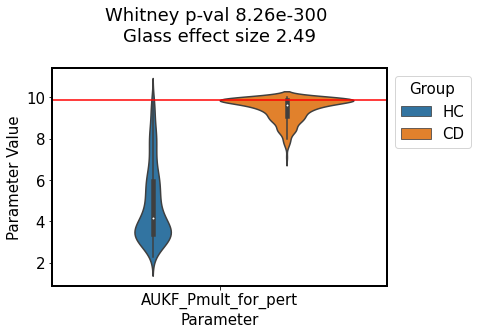

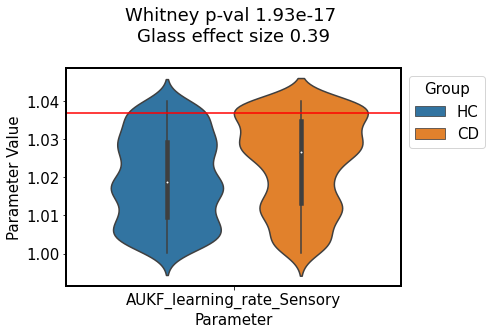

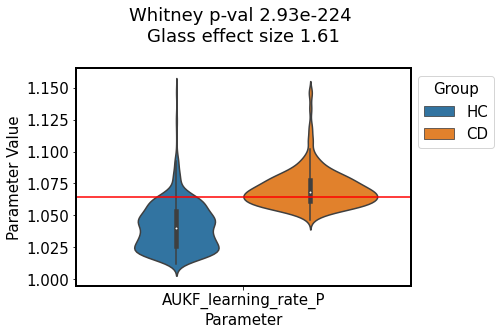

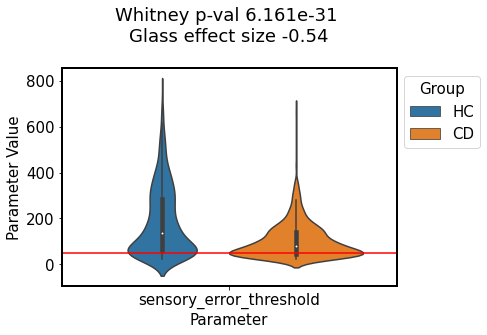

In [71]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    
    
# plt.xticks(range(0,9), labels, rotation='vertical')
# plt.ylabel('Parameter Value')
# plt.xlabel('Parameter')

# Instead of Amortized, lets try Multi-round SNPE

# Multi-round on CD

In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize

def find_multivariate_mode(data_tensor, bandwidth=0.1, kernel='gaussian'):
    # Convert PyTorch tensor to NumPy array for compatibility with KDE
    data_np = data_tensor.numpy()
    
    # Fit the KDE model to the data
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)  # Adjust bandwidth if needed
    kde.fit(data_np)

    # Define the PDF function to evaluate the density at any given point
    def pdf(x):
        log_density = kde.score_samples(x.reshape(1, -1))  # Log density for a single point
        return np.exp(log_density)  # Convert log density to regular density

    # Define the negative PDF function for minimization (since we want to maximize PDF)
    def neg_pdf(x):
        return -pdf(x)

    # Use the mean of the data as the initial guess for optimization
    initial_guess = np.mean(data_np, axis=0)

    # Minimize the negative PDF to find the mode
    result = minimize(neg_pdf, initial_guess, method='L-BFGS-B')
    mode = result.x  # This is the mode in NumPy array format

    # Convert mode back to PyTorch tensor
    mode_tensor = torch.tensor(mode, dtype=data_tensor.dtype)
    
    return mode_tensor

In [ ]:
from sbi.inference import SNPE, simulate_for_sbi
# Load posterior
path_to_files = './sbi_resources/'
obj = pd.read_pickle(f'{path_to_files}ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_CD_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'{path_to_files}ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]

In [ ]:
# If you get errors about Infs or NaNs: https://github.com/sbi-dev/sbi/issues/669
num_rounds = 10
# num_samples = 10000
num_sims = 100
posteriors_CD = []
x_o = torch.from_numpy(cereb_mean_synth)
# x_o = all_x_ds[indices[0:1],:]
proposal = posterior_CD_amort.set_default_x(x_o)

for ii in range(num_rounds):
    if ii == 0:
        num_sims = 100
    else:
        num_sims = 50   
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    # proposal2 = posterior.set_default_x(x_o)
    density_estimator_multi = inference.append_simulations(
        this_theta, this_x, proposal=proposal
    #     all_theta, all_x_ds, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=32, 
            discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_CD = inference.build_posterior(density_estimator_multi)
    posteriors_CD.append(posterior_multi_CD)
    proposal = posterior_CD_amort.set_default_x(x_o)

In [ ]:
# Save posteriors
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_{all_theta.size()[0]}_CD.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posteriors_CD], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_{all_theta.size()[0]}_CD.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)

In [ ]:
# Load posterior
print(f'{path_to_files}ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_{all_theta.size()[0]}_CD.pkl')
obj = pd.read_pickle(f'{path_to_files}ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_{all_theta.size()[0]}_CD.pkl')
print(obj)
posterior_CD_SNPE_loaded = obj[-1][-1]
# print(posterior_CD_SNPE_loaded[-1])

# Load inference
obj = pd.read_pickle(f'{path_to_files}ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_{all_theta.size()[0]}_CD.pkl')
print(obj)
inference_loaded = obj[-1]

In [ ]:
samples_cereb_multi = posteriors_CD[-1].sample((1000,), x=cereb_mean_synth)

In [ ]:
# samples_cereb_multi = posterior.sample((sample_size,), x=smoothed_cereb)

# samples_cereb_multi = posterior_multi_CD.sample((100,), x=cereb_mean_synth)
# samples_cereb_multi = posterior_CD_SNPE_loaded.sample((500,), x=cereb_mean_synth)

# posterior_modes_CD = stats.mode(samples_cereb_multi,0)
# posterior_modes_CD = torch.from_numpy(posterior_modes_CD[0][0])

# posterior_modes_CD = get_modes(samples_cereb_multi)
# posterior_modes_CD = np.median(samples_cereb_multi, axis=0)
# posterior_modes_CD = np.average(samples_cereb_multi, axis=0)
# posterior_modes_CD = torch.from_numpy(posterior_modes_CD)

# Try to find the multivariate optima
posterior_modes_CD = find_multivariate_mode(samples_cereb_multi, bandwidth=1e5, kernel='epanechnikov')

print(f'poster modes {posterior_modes_CD}')

# posterior_modes_CD_manual_test = all_theta[0,:]
# posterior_modes_CD_manual_test = posterior_modes_CD.detach().clone()
# posterior_modes_CD_manual_test[0] = all_theta[indices[0],0]
# posterior_modes_CD_manual_test[1] = all_theta[indices[0],1]
# posterior_modes_CD_manual_test[2] = all_theta[indices[0],2]
# posterior_modes_CD_manual_test[3] = all_theta[indices[0],3]
# posterior_modes_CD_manual_test[4] = all_theta[indices[0],4]
# posterior_modes_CD_manual_test[5] = all_theta[indices[0],5]
# posterior_modes_CD_manual_test[8] = all_theta[indices[0],8]
# posterior_modes_CD_manual_test[9] = all_theta[indices[0],9]
# # posterior_modes_CD_manual_test[10] = all_theta[indices[0],10]
# posterior_modes_CD_manual_test[13] = all_theta[indices[0],13]
# posterior_modes_CD_manual_test[14] = all_theta[indices[0],14]

# posterior_modes_CD_manual_test = torch.tensor([0.0064778,
#             0.0133751,
#             2.1837397 ,
#             0.0412514 , 
#             0.0000042, 
#             0.0000009 ,
#             170.7348785 ,
#             53.7720184,
#             150,
#             1,
#             8.1499996,
#             1.01,
#             1.01,
#             1.06,
#             100])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
# posterior_modes_C2 = posterior_modes_CD.clone()
# posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

# best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_CD = FACTS(posterior_modes_CD)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
#     simulated_again_best_theta = FACTS(all_theta[indices[0]])
    
    x_time = np.linspace(0,500, num=100)

    
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_CD[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_formant_manual_test[40:140], label='Manual Test')
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
#     plt.plot(x_time, simulated_again_best_theta[40:140], label='Simulated again from best theta', color='green')
    
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
# print(f'Closest training data posteriors {all_theta[indices[0:1],:]}')
# print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta}')


In [ ]:
best_theta = all_theta[indices[0:1],:]
# print(f'Closest training data posteriors {best_theta}')
# print(f'Posterior parameter value {posterior_modes_CD}')
# print(f'% difference in parameter tensors {(posterior_modes_CD - best_theta)/best_theta}')

np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)

difference_parameter_tensors = (posterior_modes_CD - best_theta[0]).numpy()
percent_diff = ( difference_parameter_tensors/best_theta*100).numpy().flatten()

difference_parameter_tensors2 = (posterior_modes_CD_manual_test - best_theta[0]).numpy()
percent_diff2 = ( difference_parameter_tensors2/best_theta*100).numpy().flatten()

# print(f'difference_parameter_tensors {difference_parameter_tensors.tolist()} {len(difference_parameter_tensors.tolist())}')
# print(f'percent_diff {percent_diff} {len(percent_diff)}')
# print(f'posterior_modes_CD_manual_test {posterior_modes_CD_manual_test} {posterior_modes_CD_manual_test.numpy().tolist()}')
# print((posterior_modes_CD - best_theta[0]).numpy().tolist())
this_df = pd.DataFrame({'Parameter label': labels,
                        'prior_min': prior_min,
                        'best training theta': best_theta[0].tolist(),
                       'posterior_modes_CD': posterior_modes_CD.numpy().tolist(),
                        'manual_test':posterior_modes_CD_manual_test.numpy().flatten().tolist(),
                        'prior_max': prior_mmax,
                       'posterior_modes_CD - best_theta': difference_parameter_tensors.tolist(),
                        'posterior_modes_CD_manual_test - best_theta / best_theta': percent_diff2,
                       'Percent diff': percent_diff,
                       })

display(this_df)

In [ ]:
# for ii, diff in enumerate(percent_diff):
#     print(difference_parameter_tensors[ii])
#     print(diff)

In [ ]:
print(posterior_modes_CD)
print(best_theta[0])
print((posterior_modes_CD - best_theta[0])/best_theta*100)
print( ( (posterior_modes_CD - best_theta[0])/best_theta*100).numpy().flatten().tolist())
print( len( ( (posterior_modes_CD - best_theta[0])/best_theta*100).numpy().flatten().tolist())) 

# Plot posteriors vs closest training sample

In [ ]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'CD Posterior Dist vs Best training parameter')
    
    
# plt.xticks(range(0,9), labels, rotation='vertical')
# plt.ylabel('Parameter Value')
# plt.xlabel('Parameter')

# Multi-round on HC

In [ ]:
from sbi.inference import SNPE, simulate_for_sbi
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]


In [ ]:
num_rounds = 10
num_sims = 100
posteriors_HC = []
x_o = torch.from_numpy(healthy_mean_synth)
proposal = posterior_amort.set_default_x(x_o)

for _ in range(num_rounds):
    if ii == 0:
        num_sims = 100
    else:
        num_sims = 50  
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    density_estimator_multi_HC = inference.append_simulations(
    this_theta, this_x, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=27, 
         discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_HC = inference.build_posterior(density_estimator_multi_HC)
    posteriors_HC.append(posterior_multi_HC)
    proposal = posterior_multi_HC.set_default_x(x_o)

In [ ]:
posterior_multi_HC = posteriors_HC[-3]

In [ ]:
# Save posteriors
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_HC_{all_theta.size()[0]}_{num_rounds}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posteriors_HC], f)
    

# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_HC_{all_theta.size()[0]}_{num_rounds}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)

In [ ]:
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_HC_5.pkl')
print(obj)
posterior_HC_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_HC_5.pkl')
print(obj)
inference = obj[0]

In [ ]:
samples_multi_HC = posterior_multi_HC.sample((1000,), x=healthy_mean_synth)

# posterior_modes_HC = stats.mode(samples_multi_HC,0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

# posterior_modes_HC = get_modes(samples_multi_HC)
# posterior_modes_HC = np.average(samples_multi_HC, axis=0)
# posterior_modes_HC = np.median(samples_multi_HC, axis=0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC)

print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()
posterior_modes_HC = find_multivariate_mode(samples_multi_HC, bandwidth=1e-26)



for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)

    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
#     plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')

In [ ]:
x_time = np.linspace(0,500, num=100)

ft_size = 28
font = {'family' : 'normal',
        'weight' : 'normal',
        }

plt.rc('font', **font)
plt.rc('axes', linewidth=2)






plt.figure(figsize=(14,10))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.8)

plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial: Cerebellar')
plt.plot(x_time, simulated_formant_CD[40:140], 'orange', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)',  fontsize=ft_size, fontweight='normal')
plt.ylabel('Formant response (Hz)', fontsize=ft_size, fontweight='normal')

plt.legend(prop={'size': ft_size*.75})
# plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empirical: Cerebellar')
plt.plot(x_time, simulated_formant_CD[40:140], 'orange', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_multi_HC).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb_multi).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

# g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

In [ ]:
from scipy.stats import mannwhitneyu
px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    #ks_stat, p_ks = stats.ks_2samp(CD_data, HC_data)
    #p_perm = permutation_test(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    sns.set(font_scale=1.5)
    sns.set_style("white")
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'],fontsize=18)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'{label}\n Glass effect size {glass_D:.2f}')
    #plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    #plt.title(f'Permutation p-val {p_perm:.4g} \nGlass effect size {glass_D:.2f}\n')
    #plt.title(f'KS p-val {p_ks:.4g} \nGlass effect size {glass_D:.2f}\n')
    

In [ ]:
def permutation_test(x, y, n_permutations=1000):
    # Concatenate the two groups
    combined = np.concatenate([x, y])

    # Calculate observed test statistic (e.g., difference in means)
    #observed_statistic = np.mean(x) - np.mean(y)
    #observed_statistic = np.median(x) - np.median(y)
    #observed_statistic = stats.mode(x)[0][0] - stats.mode(y)[0][0]
    observed_statistic = stats.ks_2samp(x , y)[0]
    #observed_statistic = get_modes(x.to_numpy().reshape(-1,1)) - get_modes(y.to_numpy().reshape(-1,1))
    
    # Initialize an array to store permutation test statistics
    permutation_stats = np.zeros(n_permutations)

    # Perform permutations
    for i in range(n_permutations):
        # Permute the combined data
        permuted_data = np.random.permutation(combined)

        # Split the permuted data into two groups
        permuted_x = permuted_data[:len(x)]
        permuted_y = permuted_data[len(x):]

        # Calculate the test statistic for this permutation
        #permutation_stats[i] = np.mean(permuted_x) - np.mean(permuted_y)
        #permutation_stats[i] = np.median(permuted_x) - np.median(permuted_y)
        #permutation_stats[i] = stats.mode(permuted_x)[0][0] - stats.mode(permuted_y)[0][0]
        permutation_stats[i] = stats.ks_2samp(permuted_x, permuted_y)[0]
        #permutation_stats[i] = get_modes(permuted_x.reshape(-1,1)) - get_modes(permuted_y.reshape(-1,1))

    # Calculate p-value
    p_value = np.mean(np.abs(permutation_stats) >= np.abs(observed_statistic))

    return p_value